### Loading Packages and Data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

In [4]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [7]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/'

# Loading and Cleaning Data

### Load Data

In [8]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

In [9]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv').reset_index()
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv').reset_index()
yld = yld.rename(columns = {'value':'yld', 'cause_of_disability':'cause'})
daly = yll.merge(yld, on = ['sex','year','cause','input_draw','scenario','age','location'], how='left')
daly['daly'] = daly.yll.fillna(0) + daly.yld.fillna(0)
daly = daly[['sex','year','cause','input_draw','scenario','age','location','yll','yld','daly']]
daly.head()

sex  year                  cause  input_draw       scenario       age  \
0  Female  2021  acute_ischemic_stroke          29       baseline  25_to_29   
1  Female  2021  acute_ischemic_stroke          29  lifestyle_100  25_to_29   
2  Female  2021  acute_ischemic_stroke          29   outreach_100  25_to_29   
3  Female  2021  acute_ischemic_stroke          29   polypill_100  25_to_29   
4  Female  2021  acute_ischemic_stroke          29       baseline  30_to_34   

     location  yll       yld      daly  
0  washington  0.0  0.000244  0.000244  
1  washington  0.0  0.000244  0.000244  
2  washington  0.0  0.000244  0.000244  
3  washington  0.0  0.000244  0.000244  
4  washington  0.0  0.000076  0.000076

### Load Population Data for Scaling 

In [10]:
US_pop = get_population(age_group_id=157, 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)
#US_pop.head()

In [11]:
location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop['scalar'] = US_pop['population'] / 50_000
US_pop.head()

age_group_id  location_id  year_id  sex_id    population  run_id  \
0           157          102     2019       3  2.260218e+08     359   
1           157          523     2019       3  3.425549e+06     359   
2           157          524     2019       3  4.848432e+05     359   
3           157          525     2019       3  4.812495e+06     359   
4           157          526     2019       3  2.020596e+06     359   

  location_name abbreviation       scalar  
0            US           US  4520.435794  
1       Alabama           AL    68.510979  
2        Alaska           AK     9.696864  
3       Arizona           AZ    96.249902  
4      Arkansas           AR    40.411911

### Scale Datasets

# Create Dataset with Needed Outcomes 
•	MI, stroke, and HF incidence rates + counts 

•	IHD (MI + post-MI + HF from IHD), stroke, and HF DALYs 

•	Percent change and counts 

•	National and PDFs with states 

### Starting with Incidence Counts for MI, stroke, and HF 

In [12]:
#tran.transition.unique()

In [13]:
tran = tran.loc[tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke'])]
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state = tran.groupby(['input_draw','year','scenario','location','transition_new']).value.sum().reset_index()
tran_state['location_name'] = tran_state.location.str.capitalize()
tran_state = tran_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
tran_state['value'] = tran_state['value'] * tran_state['scalar']
tran_US = tran_state.groupby(['input_draw','year','scenario','transition_new']).value.sum().reset_index()
#tran_US.head()

In [14]:
tran_state_allyear = tran_state.groupby(['input_draw','scenario','transition_new','location_name','abbreviation']).value.sum().reset_index()
tran_US_allyear = tran_state.groupby(['input_draw','scenario','transition_new']).value.sum().reset_index()
tran_state_allyear.head()

input_draw  scenario transition_new location_name abbreviation  \
0          29  baseline  Heart Failure       Alabama           AL   
1          29  baseline  Heart Failure        Alaska           AK   
2          29  baseline  Heart Failure       Arizona           AZ   
3          29  baseline  Heart Failure      Arkansas           AR   
4          29  baseline  Heart Failure    California           CA   

          value  
0  4.716296e+05  
1  5.425395e+04  
2  6.775031e+05  
3  2.973913e+05  
4  3.791522e+06

In [15]:
tran_state_baseline = tran_state.loc[tran_state.scenario == 'baseline']
tran_state_baseline = tran_state_baseline.rename(columns = {'value':'baseline'})
tran_state_total = tran_state.merge(tran_state_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
tran_state_total['averted_count'] = tran_state_total['baseline'] - tran_state_total['value']
tran_state_total['averted_percent'] = 100*((tran_state_total['baseline'] - tran_state_total['value'])/tran_state_total['baseline'])
#tran_state_total.head()

In [16]:
def q25(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

In [17]:
tran_state_summ = (tran_state_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'value':['mean',q25,q975]}))
#tran_state_summ.head()

In [18]:
tran_state_summ.columns = ["_".join(a) for a in tran_state_summ.columns.to_flat_index()]
tran_state_summ.reset_index(inplace=True)
#tran_state_summ.head()

In [19]:
tran_state_allyear_baseline = tran_state_allyear.loc[tran_state_allyear.scenario == 'baseline']
tran_state_allyear_baseline = tran_state_allyear_baseline.rename(columns = {'value':'baseline'})
tran_state_allyear_total = tran_state_allyear.merge(tran_state_allyear_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_allyear_total['averted_count'] = tran_state_allyear_total['baseline'] - tran_state_allyear_total['value']
tran_state_allyear_total['averted_percent'] = 100*((tran_state_allyear_total['baseline'] - tran_state_allyear_total['value'])/tran_state_allyear_total['baseline'])
tran_state_allyear_total.head()

input_draw       scenario transition_new location_name abbreviation  \
0          29       baseline  Heart Failure       Alabama           AL   
1          29  lifestyle_100  Heart Failure       Alabama           AL   
2          29   outreach_100  Heart Failure       Alabama           AL   
3          29   polypill_100  Heart Failure       Alabama           AL   
4          29       baseline  Heart Failure        Alaska           AK   

           value       baseline  averted_count  averted_percent  
0  471629.581988  471629.581988       0.000000         0.000000  
1  470875.961215  471629.581988     753.620773         0.159791  
2  471081.494153  471629.581988     548.087835         0.116212  
3  467724.456164  471629.581988    3905.125824         0.828007  
4   54253.954463   54253.954463       0.000000         0.000000

In [20]:
tran_state_allyear_summ = (tran_state_allyear_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'value':['mean',q25,q975]}))
tran_state_allyear_summ.head()

averted_count  \
                                                                  mean   
location_name abbreviation transition_new  scenario                      
Alabama       AL           Heart Failure   baseline           0.000000   
                                           lifestyle_100   1520.943742   
                                           outreach_100     459.023562   
                                           polypill_100    5289.047607   
                           Ischemic Stroke baseline           0.000000   

                                                                       \
                                                                  q25   
location_name abbreviation transition_new  scenario                     
Alabama       AL           Heart Failure   baseline          0.000000   
                                           lifestyle_100   769.035743   
                                           outreach_100    -37.681039   
                                           polypill_100   2802.099056   
                           Ischemic Stroke baseline          0.000000   

                                                                        \
                                                                  q975   
location_name abbreviation transition_new  scenario                      
Alabama       AL           Heart Failure   baseline           0.000000   
                                           lifestyle_100   2420.150346   
                                           outreach_100    1103.026768   
                                           polypill_100   10167.029339   
                           Ischemic Stroke baseline           0.000000   

                                                         averted_percent  \
                                                                    mean   
location_name abbreviation transition_new  scenario                        
Alabama       AL           Heart Failure   baseline             0.000000   
                                           lifestyle_100        0.284798   
                                           outreach_100         0.086374   
                                           polypill_100         0.971431   
                           Ischemic Stroke baseline             0.000000   

                                                                              \
                                                               q25      q975   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.000000  0.000000   
                                           lifestyle_100  0.154727  0.467837   
                                           outreach_100  -0.007143  0.187263   
                                           polypill_100   0.547324  1.729908   
                           Ischemic Stroke baseline       0.000000  0.000000   

                                                                  value  \
                                                                   mean   
location_name abbreviation transition_new  scenario                       
Alabama       AL           Heart Failure   baseline       537674.166102   
                                           lifestyle_100  536153.222360   
                                           outreach_100   537215.142540   
                                           polypill_100   532385.118494   
                           Ischemic Stroke baseline       102725.362469   

                                                                         \
                                                                    q25   
location_name abbreviation transition_new  scenario                       
Alabama       AL           Heart Failure   baseline       479028.767760   
                                           lifestyle_100  477936.017640   
                                           outreach_100   47

In [21]:
tran_state_allyear_summ.columns = ["_".join(a) for a in tran_state_allyear_summ.columns.to_flat_index()]
tran_state_allyear_summ.reset_index(inplace=True)
tran_state_allyear_summ.head()

location_name abbreviation   transition_new       scenario  \
0       Alabama           AL    Heart Failure       baseline   
1       Alabama           AL    Heart Failure  lifestyle_100   
2       Alabama           AL    Heart Failure   outreach_100   
3       Alabama           AL    Heart Failure   polypill_100   
4       Alabama           AL  Ischemic Stroke       baseline   

   averted_count_mean  averted_count_q25  averted_count_q975  \
0            0.000000           0.000000            0.000000   
1         1520.943742         769.035743         2420.150346   
2          459.023562         -37.681039         1103.026768   
3         5289.047607        2802.099056        10167.029339   
4            0.000000           0.000000            0.000000   

   averted_percent_mean  averted_percent_q25  averted_percent_q975  \
0              0.000000             0.000000              0.000000   
1              0.284798             0.154727              0.467837   
2              0.086374            -0.007143              0.187263   
3              0.971431             0.547324              1.729908   
4              0.000000             0.000000              0.000000   

      value_mean      value_q25     value_q975  
0  537674.166102  479028.767760  605354.449848  
1  536153.222360  477936.017640  604006.496329  
2  537215.142540  478419.020044  604436.402724  
3  532385.118494  474383.723359  596218.510749  
4  102725.362469   59220.890568  243498.297331

In [22]:
#negative = tran_state_allyear_summ.loc[(tran_state_allyear_summ.averted_percent_mean < 0.2) & (tran_state_allyear_summ.scenario != 'baseline')] 
#negative #.transition_new.unique()

In [23]:
tran_US_baseline = tran_US.loc[tran_US.scenario == 'baseline']
tran_US_baseline = tran_US_baseline.rename(columns = {'value':'baseline'})
tran_US_total = tran_US.merge(tran_US_baseline[['input_draw','year','transition_new','baseline']], on=['input_draw','year','transition_new']) 
tran_US_total['averted_count'] = tran_US_total['baseline'] - tran_US_total['value']
tran_US_total['averted_percent'] = 100*((tran_US_total['baseline'] - tran_US_total['value'])/tran_US_total['baseline'])
#tran_US_total.head()

In [24]:
tran_US_summ = (tran_US_total
                      .groupby(['year','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'value':['mean',q25,q975]}))
#tran_US_summ.head()

In [25]:
tran_US_summ.columns = ["_".join(a) for a in tran_US_summ.columns.to_flat_index()]
tran_US_summ.reset_index(inplace=True)
#tran_US_summ.head()

### Now Making Datasets for DALYs for IHD, stroke, and heart failure

In [26]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
daly_state = daly.groupby(['input_draw','year','scenario','location','transition_new']).daly.sum().reset_index()
daly_state['location_name'] = daly_state.location.str.capitalize()
daly_state = daly_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
daly_state['daly'] = daly_state['daly'] * daly_state['scalar']
daly_US = daly_state.groupby(['input_draw','year','scenario','transition_new']).daly.sum().reset_index()
#daly_US.head()

daly_state_allyear = daly_state.groupby(['input_draw','scenario','location_name','abbreviation']).daly.sum().reset_index()
daly_US_allyear = daly_state.groupby(['input_draw','scenario']).daly.sum().reset_index()
daly_state_allyear.head()

#""""
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
daly_state = daly.groupby(['year','input_draw','scenario','location','transition_new']).daly.sum().reset_index()
#person_time_all = person_time.groupby(['input_draw','scenario','location']).value.sum().reset_index()

#daly_state_rate = daly_state.merge(person_time_all[['input_draw','scenario','location','value']], on=['input_draw','scenario','location'])
#daly_state_rate['daly_rate'] = daly_state_rate['daly'] / daly_state_rate['value']
daly_state['location_name'] = daly_state.location.str.capitalize()
#daly_US_rate = daly_state_rate.groupby(['input_draw','scenario','transition_new']).daly_rate.sum().reset_index()
#daly_US_rate.head()

In [23]:
daly_state_baseline = daly_state.loc[daly_state.scenario == 'baseline']
daly_state_baseline = daly_state_baseline.rename(columns = {'daly':'baseline'})
daly_state_total = daly_state.merge(daly_state_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
daly_state_total['averted_count'] = daly_state_total['baseline'] - daly_state_total['daly']
daly_state_total['averted_percent'] = 100*((daly_state_total['baseline'] - daly_state_total['daly'])/daly_state_total['baseline'])
#daly_state_total.head()

In [24]:
daly_state_summ = (daly_state_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
#daly_state_summ.head()

In [25]:
daly_state_summ.columns = ["_".join(a) for a in daly_state_summ.columns.to_flat_index()]
daly_state_summ.reset_index(inplace=True)
#daly_state_summ.head()

daly_state_allyear_baseline = daly_state_allyear.loc[daly_state_allyear.scenario == 'baseline']
daly_state_allyear_baseline = daly_state_allyear_baseline.rename(columns = {'daly':'baseline'})
daly_state_allyear_total = daly_state_allyear.merge(daly_state_allyear_baseline[['input_draw','location_name','baseline']], on=['input_draw','location_name']) 
daly_state_allyear_total['averted_count'] = daly_state_allyear_total['baseline'] - daly_state_allyear_total['daly']
daly_state_allyear_total['averted_percent'] = 100*((daly_state_allyear_total['baseline'] - daly_state_allyear_total['daly'])/daly_state_allyear_total['baseline'])
daly_state_allyear_total.head()

daly_state_allyear_summ = (daly_state_allyear_total
                      .groupby(['location_name','abbreviation','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
daly_state_allyear_summ.head()

daly_state_allyear_summ.columns = ["_".join(a) for a in daly_state_allyear_summ.columns.to_flat_index()]
daly_state_allyear_summ.reset_index(inplace=True)
daly_state_allyear_summ.head()

In [26]:
#negative = daly_state_allyear_summ.loc[daly_state_allyear_summ.averted_count_mean < 0] 
#negative#.transition_new.unique()

#"""
daly_state_rate_baseline = daly_state_rate.loc[daly_state_rate.scenario == 'baseline']
daly_state_rate_baseline = daly_state_rate_baseline.rename(columns = {'daly_rate':'baseline'})
daly_state_rate_total = daly_state_rate.merge(daly_state_rate_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
daly_state_rate_total['averted_count'] = daly_state_rate_total['baseline'] - daly_state_rate_total['daly_rate']
daly_state_rate_total['averted_percent'] = 100*((daly_state_rate_total['baseline'] - daly_state_rate_total['daly_rate'])/daly_state_rate_total['baseline'])
daly_state_rate_total.head()

#"""
daly_state_rate_summ = (daly_state_rate_total
                      .groupby(['location_name','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly_rate':['mean',q25,q975]}))
daly_state_rate_summ.head()

#"""
daly_state_rate_summ.columns = ["_".join(a) for a in daly_state_rate_summ.columns.to_flat_index()]
daly_state_rate_summ.reset_index(inplace=True)
daly_state_rate_summ.head()

negative = daly_state_rate_summ.loc[daly_state_rate_summ.averted_count_mean < 0] 
negative#.transition_new.unique()

In [27]:
daly_US_baseline = daly_US.loc[daly_US.scenario == 'baseline']
daly_US_baseline = daly_US_baseline.rename(columns = {'daly':'baseline'})
daly_US_total = daly_US.merge(daly_US_baseline[['input_draw','year','transition_new','baseline']], on=['input_draw','year','transition_new']) 
daly_US_total['averted_count'] = daly_US_total['baseline'] - daly_US_total['daly']
daly_US_total['averted_percent'] = 100*((daly_US_total['baseline'] - daly_US_total['daly'])/daly_US_total['baseline'])
#daly_US_total.head()

In [28]:
daly_US_summ = (daly_US_total
                      .groupby(['year','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
#daly_US_summ.head()

In [29]:
daly_US_summ.columns = ["_".join(a) for a in daly_US_summ.columns.to_flat_index()]
daly_US_summ.reset_index(inplace=True)
#daly_US_summ.head()

### Converting Datasets a Bit for Scatterplots

In [30]:
tran_state_scatter = pd.DataFrame()
tran_state_scatter[['year','transition_new','location_name','abbreviation','scenario','value_mean','averted_count_mean','averted_percent_mean']] = tran_state_summ[['year','transition_new','location_name','abbreviation','scenario','value_mean','averted_count_mean','averted_percent_mean']]
tran_state_scatter_2023 = tran_state_scatter.loc[tran_state_scatter.year==2023].reset_index()
tran_state_scatter_2023 = tran_state_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_state_scatter_2040 = tran_state_scatter.loc[tran_state_scatter.year==2040].reset_index()
tran_state_scatter_2040 = tran_state_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_state_scatter = pd.concat([tran_state_scatter_2023, tran_state_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_state_scatter.head()

In [31]:
tran_us_scatter = pd.DataFrame()
tran_us_scatter[['year','transition_new','scenario','value_mean','averted_count_mean','averted_percent_mean']] = tran_US_summ[['year','transition_new','scenario','value_mean','averted_count_mean','averted_percent_mean']]
tran_us_scatter_2023 = tran_us_scatter.loc[tran_us_scatter.year==2023].reset_index()
tran_us_scatter_2023 = tran_us_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_us_scatter_2040 = tran_us_scatter.loc[tran_us_scatter.year==2040].reset_index()
tran_us_scatter_2040 = tran_us_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_us_scatter = pd.concat([tran_us_scatter_2023, tran_us_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_us_scatter.head()

In [32]:
DALY_state_scatter = pd.DataFrame()
DALY_state_scatter[['year','transition_new','location_name','abbreviation','scenario','daly_mean','averted_count_mean','averted_percent_mean']] = daly_state_summ[['year','transition_new','location_name','abbreviation','scenario','daly_mean','averted_count_mean','averted_percent_mean']]
DALY_state_scatter = DALY_state_scatter.rename(columns = {'daly_mean':'value_mean'})
DALY_state_scatter_2023 = DALY_state_scatter.loc[DALY_state_scatter.year==2023].reset_index()
DALY_state_scatter_2023 = DALY_state_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
DALY_state_scatter_2040 = DALY_state_scatter.loc[DALY_state_scatter.year==2040].reset_index()
DALY_state_scatter_2040 = DALY_state_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
DALY_state_scatter = pd.concat([DALY_state_scatter_2023, DALY_state_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#DALY_state_scatter.head()

In [33]:
DALY_us_scatter = pd.DataFrame()
DALY_us_scatter[['year','transition_new','scenario','daly_mean','averted_count_mean','averted_percent_mean']] = daly_US_summ[['year','transition_new','scenario','daly_mean','averted_count_mean','averted_percent_mean']]
DALY_us_scatter = DALY_us_scatter.rename(columns = {'daly_mean':'value_mean'})
DALY_us_scatter_2023 = DALY_us_scatter.loc[DALY_us_scatter.year==2023].reset_index()
DALY_us_scatter_2023 = DALY_us_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
DALY_us_scatter_2040 = DALY_us_scatter.loc[DALY_us_scatter.year==2040].reset_index()
DALY_us_scatter_2040 = DALY_us_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
DALY_us_scatter = pd.concat([DALY_us_scatter_2023, DALY_us_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#DALY_us_scatter.head()

# Make Graphs 

In [34]:
def total_outcome_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:

        for scenario in data.scenario.unique():
            for tran in data.transition_new.unique(): 
                f, ax = plt.subplots(figsize=(6, 6))

                subdata = data.loc[(data.transition_new==tran) & (data.scenario==scenario)]
                ax.scatter(subdata.value_mean_2023, subdata.value_mean_2040, marker = 'o')

                for i in range(len(subdata)):
                    ax.annotate(subdata.abbreviation.iloc[i], (subdata.value_mean_2023.iloc[i], subdata.value_mean_2040.iloc[i] + 0.0002))

                ax.set_xlabel(f'{tran} {outcome} 2023')
                ax.set_ylabel(f'{tran} {outcome} 2040')
                low_y, high_y = ax.get_ylim()
                ax.set_xlim(low_y,high_y)
                diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
                plt.title(f'Comparing {tran} {outcome} Change with {scenario}')
                pdf.savefig(bbox_inches='tight')

In [35]:
def comparison_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:
        for tran in data.transition_new.unique(): 

            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
            fig.tight_layout(pad=20)
            fig.suptitle(f'Comparing {tran} {outcome} Percent Averted in Different Scenarios',)

            subdata_polypill = data.loc[(data.transition_new==tran) & (data.scenario=='polypill_100')]
            subdata_outreach = data.loc[(data.transition_new==tran) & (data.scenario=='outreach_100')]
            subdata_lifestyle = data.loc[(data.transition_new==tran) & (data.scenario=='lifestyle_100')]

            ax1.scatter(subdata_polypill.averted_percent_mean, subdata_outreach.averted_percent_mean, marker = 'o')

            for i in range(len(subdata_polypill)):
                ax1.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_outreach.averted_percent_mean.iloc[i] + 0.0002))

            ax1.set_xlabel(f'Polypill')
            ax1.set_ylabel(f'Outreach')
            #low_y, high_y = ax1.get_xlim()
            ax1.set_xlim(-0.4,10)
            ax1.set_ylim(-0.4,10)
            diag_line = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
            ax1.set_title(f'Polypill vs Outreach')



            ax2.scatter(subdata_polypill.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

            for i in range(len(subdata_polypill)):
                ax2.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

            ax2.set_xlabel(f'Polypill')
            ax2.set_ylabel(f'Lifestyle')
            ax2.set_xlim(-0.4,10)
            ax2.set_ylim(-0.4,10)
            diag_line = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
            ax2.set_title(f'Polypill vs Lifestyle')
            plt.tight_layout()


            ax3.scatter(subdata_outreach.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

            for i in range(len(subdata_outreach)):
                ax3.annotate(subdata_outreach.abbreviation.iloc[i], (subdata_outreach.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

            ax3.set_xlabel(f'Outreach')
            ax3.set_ylabel(f'Lifestyle')
            ax3.set_xlim(-0.4,10)
            ax3.set_ylim(-0.4,10)
            diag_line = ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
            ax3.set_title(f'Outreach vs Lifestyle')
            plt.tight_layout()
            pdf.savefig(bbox_inches='tight')

In [36]:
def comparison_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
        fig.tight_layout(pad=20)
        fig.suptitle(f'Comparing {outcome} Percent Averted in Different Scenarios',)

        subdata_polypill = data.loc[(data.scenario=='polypill_100')]
        subdata_outreach = data.loc[(data.scenario=='outreach_100')]
        subdata_lifestyle = data.loc[(data.scenario=='lifestyle_100')]

        ax1.scatter(subdata_polypill.averted_percent_mean, subdata_outreach.averted_percent_mean, marker = 'o')

        for i in range(len(subdata_polypill)):
            ax1.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_outreach.averted_percent_mean.iloc[i] + 0.0002))

        ax1.set_xlabel(f'Polypill')
        ax1.set_ylabel(f'Outreach')
        low_y, high_y = ax1.get_xlim()
        ax1.set_xlim(0,3)
        ax1.set_ylim(0,3)
        diag_line = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
        ax1.set_title(f'Polypill vs Outreach')



        ax2.scatter(subdata_polypill.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

        for i in range(len(subdata_polypill)):
            ax2.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

        ax2.set_xlabel(f'Polypill')
        ax2.set_ylabel(f'Lifestyle')
        ax2.set_xlim(0,3)
        ax2.set_ylim(0,3)
        diag_line = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
        ax2.set_title(f'Polypill vs Lifestyle')
        plt.tight_layout()


        ax3.scatter(subdata_outreach.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

        for i in range(len(subdata_outreach)):
            ax3.annotate(subdata_outreach.abbreviation.iloc[i], (subdata_outreach.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

        ax3.set_xlabel(f'Outreach')
        ax3.set_ylabel(f'Lifestyle')
        ax3.set_xlim(0,1)
        ax3.set_ylim(0,1)
        diag_line = ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
        ax3.set_title(f'Outreach vs Lifestyle')
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')

In [47]:
tran_US_summ.transition_new.unique()

array(['Heart Failure', 'Ischemic Stroke', 'Myocardial Infarction'],
      dtype=object)

In [49]:
def us_graphs(data, outcome, pdf_title): 
    with PdfPages(pdf_title) as pdf:
        for trans in ['Myocardial Infarction']: #data.transition_new.unique():

            plt.figure()
            plt.suptitle(f'Reduction in {trans} {outcome} for US')

            plt.subplot(1, 2, 1)
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Baseline')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = 'Baseline 95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Lifestyle: Community-based National Diabetes Prevention Program')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = '95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Outreach: Nurse intervention to increase adherence of hypertension and dyslipdemia medications at initiation')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = '95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o',label = 'Polypill: Fixed-dose combination anti-hypertensive with routine up-titration')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = '95%')
            plt.title('Count Reduction')
            plt.xlabel('Year')
            plt.ylabel(f'Reduction in {trans} {outcome} Count')

            plt.subplot(1, 2, 2)
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Baseline')
            plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Baseline 95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Lifestyle: Community-based National Diabetes Prevention Program')
            plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Lifestyle 95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Outreach: Nurse intervention to increase adherence of hypertension and dyslipdemia medications at initiation')
            plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Outreach 95%')
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o',label = 'Polypill: Fixed-dose combination anti-hypertensive with routine up-titration')
            plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Polypill 95%')
            plt.title('Percent Reduction')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('Year')
            plt.ylabel(f'Percent Reduction in {trans} {outcome}')
            pdf.savefig(bbox_inches='tight')

In [50]:
def state_graphs(data, outcome, pdf_title): 
    with PdfPages(pdf_title) as pdf:
        for state in data.location_name.unique():
            for trans in ['Myocardial Infarction']: #data.transition_new.unique():

                plt.figure()
                plt.suptitle(f'Reduction in {trans} {outcome} for {state}')

                plt.subplot(1, 2, 1)
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='baseline')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Baseline')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = 'Baseline 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='lifestyle_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Lifestyle: Community-based National Diabetes Prevention Program')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = 'Lifestyle 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='outreach_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Outreach: Nurse intervention to increase adherence of hypertension and dyslipdemia medications at initiation')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = 'Outreach 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='polypill_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o',label = 'Polypill: Fixed-dose combination anti-hypertensive with routine up-titration')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3, label = 'Polypill 95%')
                plt.title('Count Reduction')
                plt.xlabel('Year')
                plt.ylabel(f'Reduction in {trans} {outcome} Count')

                plt.subplot(1, 2, 2)
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='baseline')]
                plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Baseline')
                plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Baseline 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='lifestyle_100')]
                plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Lifestyle: Community-based National Diabetes Prevention Program')
                plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Lifestyle 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='outreach_100')]
                plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o', label = 'Outreach: Nurse intervention to increase adherence of hypertension and dyslipdemia medications at initiation')
                plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Outreach 95%')
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='polypill_100')]
                plt.plot(subdata['year'], subdata['averted_percent_mean'], marker = 'o',label = 'Polypill: Fixed-dose combination anti-hypertensive with routine up-titration')
                plt.fill_between(subdata['year'], subdata['averted_percent_q25'], subdata['averted_percent_q975'], alpha = 0.3, label = 'Polypill 95%')
                plt.title('Percent Reduction')
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.xlabel('Year')
                plt.ylabel(f'Percent Reduction in {trans} {outcome}')
                pdf.savefig(bbox_inches='tight')

In [44]:
def bar_chart_state(data, outcome, pdf_title):
    with PdfPages(pdf_title) as pdf:
        for state in data.location_name.unique():
            plt.figure()
            subdata = data.loc[(data.scenario == 'baseline') & (data.location_name == state)]

            x = np.arange(len(subdata.value_mean_2023))
            width = 0.40

            # plot data in grouped manner of bar type
            plt.bar(x-0.2, subdata.value_mean_2023, width, label = '2023')
            plt.bar(x+0.2, subdata.value_mean_2040, width, label = '2040')

            plt.xticks(x, subdata.transition_new)
            plt.ylabel('Total Incidence')
            plt.title(f'Comparing {outcome} in 2023 and 2040 in {state}')
            plt.legend()
            pdf.savefig(bbox_inches='tight')

In [45]:
def bar_chart_us(data, outcome, pdf_title):
    with PdfPages(pdf_title) as pdf:
        plt.figure()
        subdata = data.loc[(data.scenario == 'baseline')]

        x = np.arange(len(subdata.value_mean_2023))
        width = 0.40

        # plot data in grouped manner of bar type
        plt.bar(x-0.2, subdata.value_mean_2023, width, label = '2023')
        plt.bar(x+0.2, subdata.value_mean_2040, width, label = '2040')

        plt.xticks(x, subdata.transition_new)
        plt.ylabel(f'{outcome}')
        plt.title(f'Comparing {outcome} in 2023 and 2040 in US')
        plt.legend()
        pdf.savefig(bbox_inches='tight')

In [37]:
def nih_us_graphs(data, outcome, pdf_title): 
    with PdfPages(pdf_title) as pdf:
        for trans in ['Myocardial Infarction']: #data.transition_new.unique():

            plt.figure()
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Baseline')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Community-based NDPP')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
            subdata = data.loc[(data.transition_new==trans) & (data.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o',label = 'FDC antihypertensive')
            plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
            plt.title('Count Reduction in Myocardial Infarction')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xlabel('Year')
            plt.ylabel(f'Reduction in {trans} {outcome} Count')
            pdf.savefig(bbox_inches='tight')

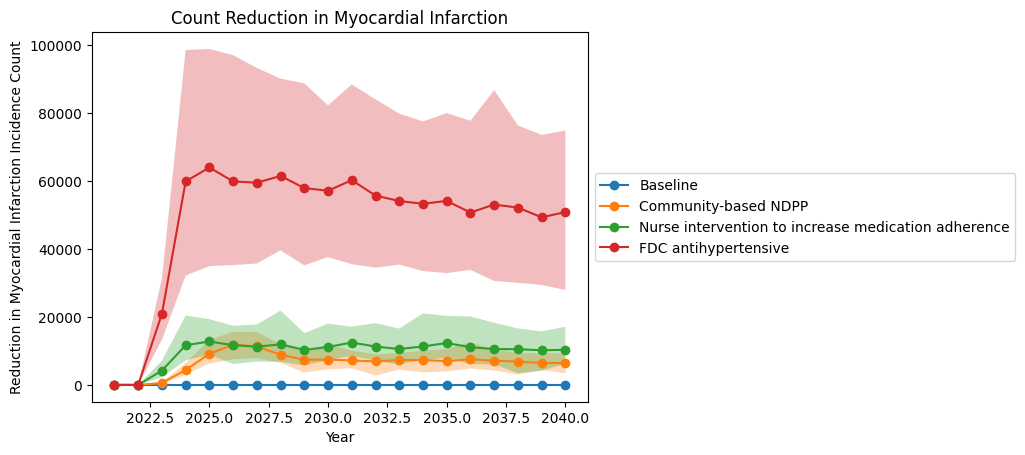

In [38]:
#%%capture
nih_us_graphs(tran_US_summ, 'Incidence', 'incidence_us_10_26_2023.pdf')

In [45]:
def nih_state_graphs(data, outcome, pdf_title): 
    with PdfPages(pdf_title) as pdf:
        for state in data.location_name.unique():
            for trans in ['Myocardial Infarction']: #data.transition_new.unique():

                plt.figure()
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='baseline')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Baseline')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='lifestyle_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Community-based NDPP')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='outreach_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
                subdata = data.loc[(data.transition_new==trans) & (data.location_name==state) & (data.scenario=='polypill_100')]
                plt.plot(subdata['year'], subdata['averted_count_mean'], marker = 'o',label = 'FDC antihypertensive')
                plt.fill_between(subdata['year'], subdata['averted_count_q25'], subdata['averted_count_q975'], alpha = 0.3)
                plt.title(f'Count Reduction in Myocardial Infarction in {state}')
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                plt.xlabel('Year')
                plt.ylabel(f'Reduction in {trans} {outcome} Count')
                pdf.savefig(bbox_inches='tight')

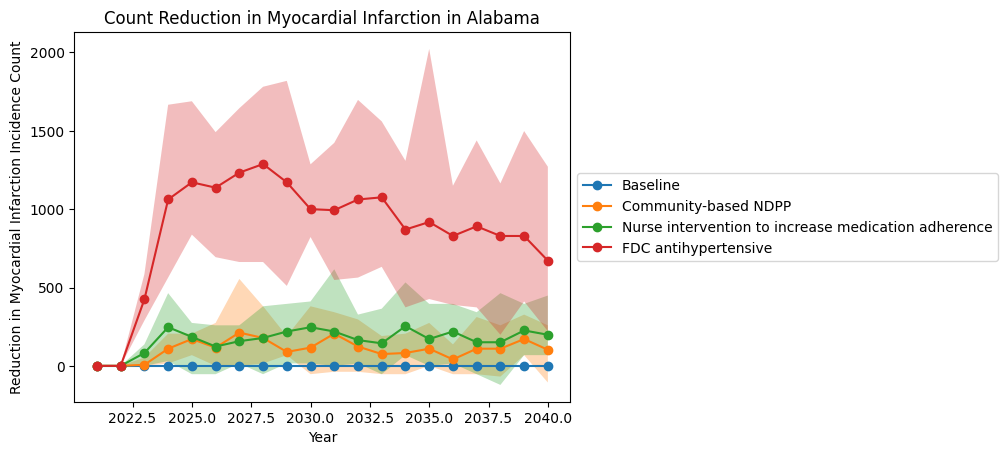

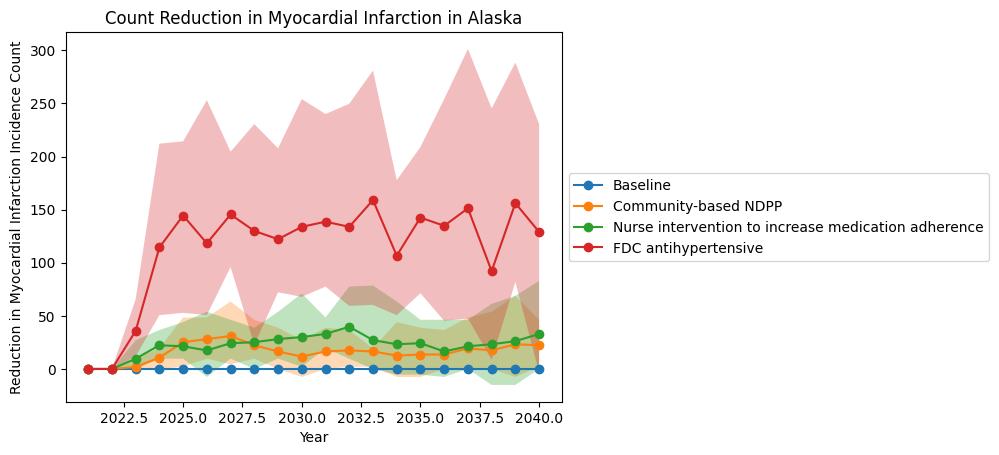

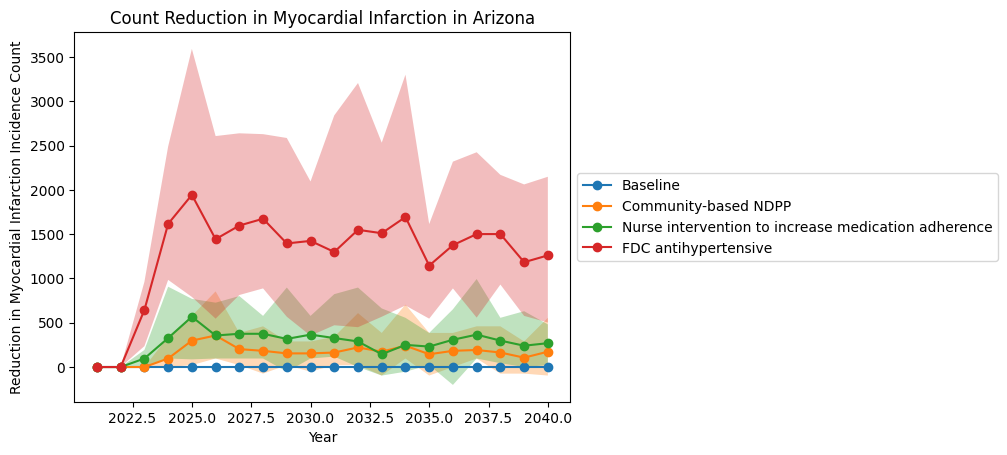

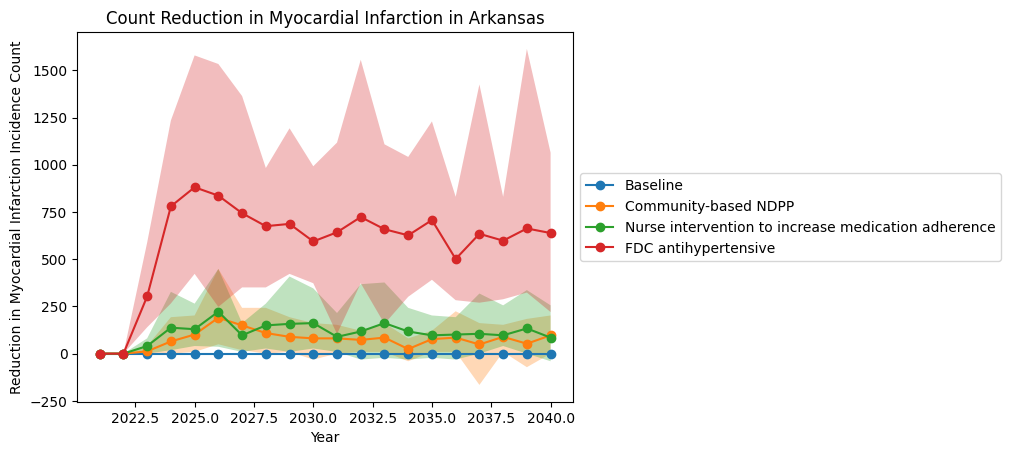

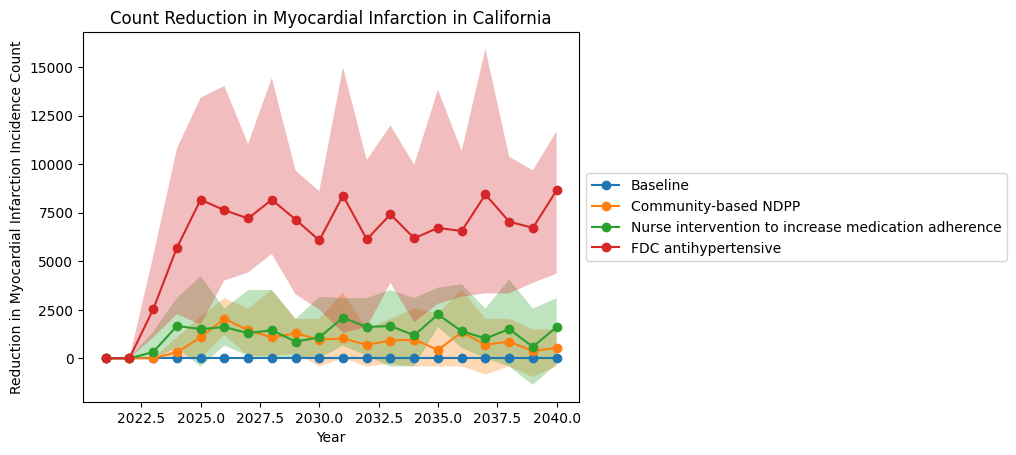

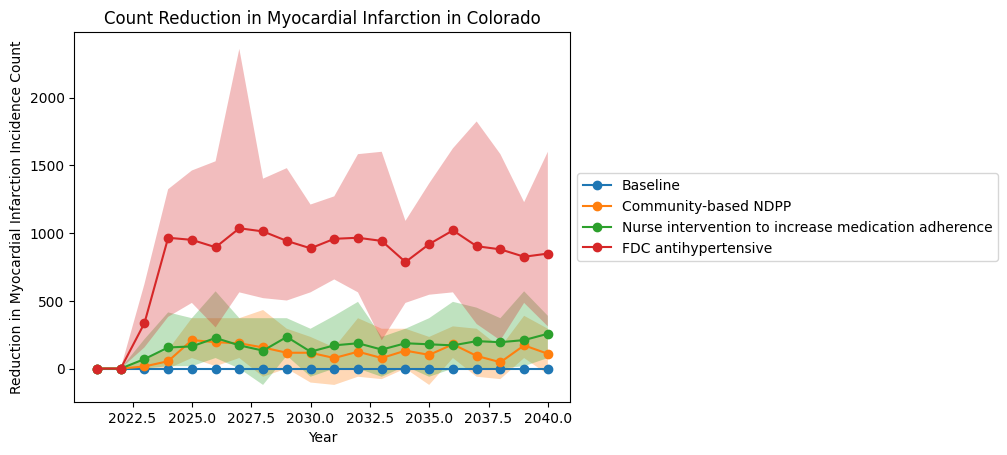

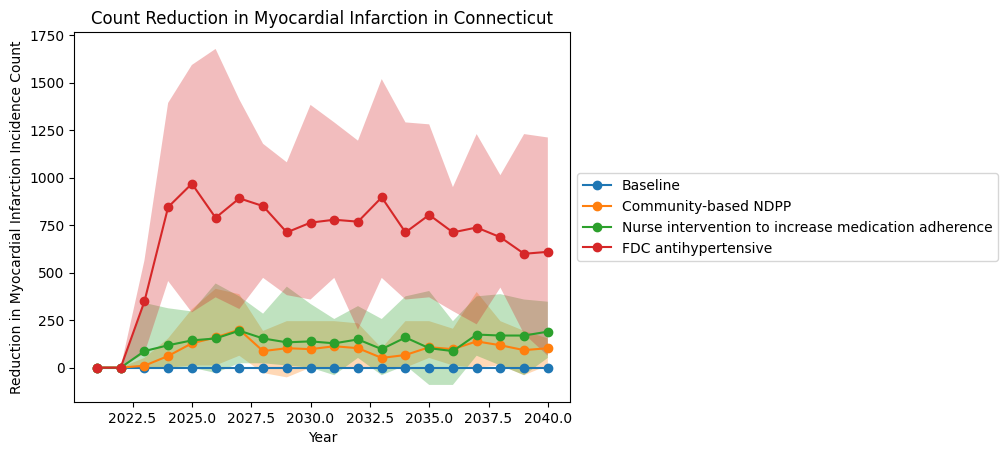

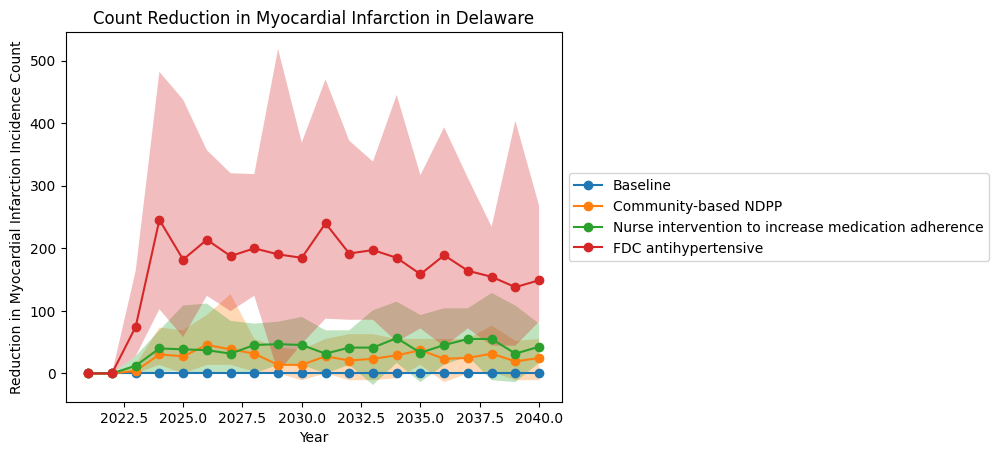

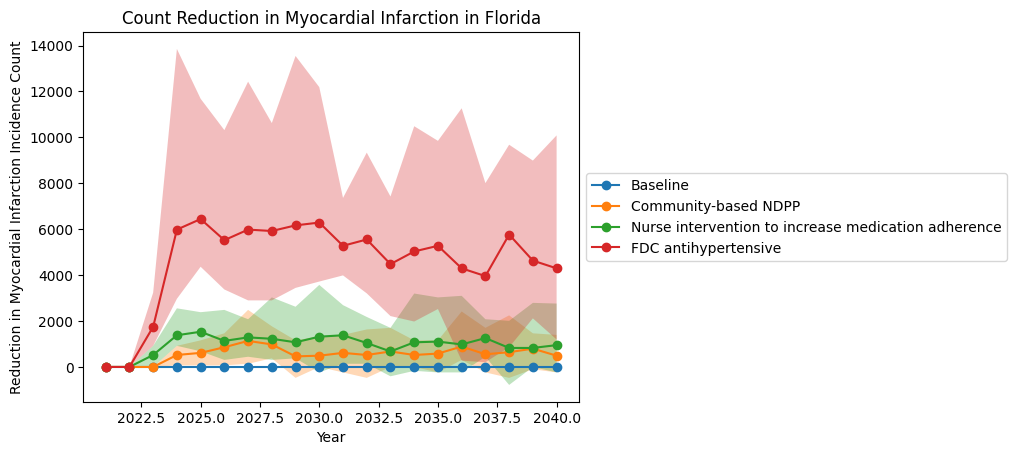

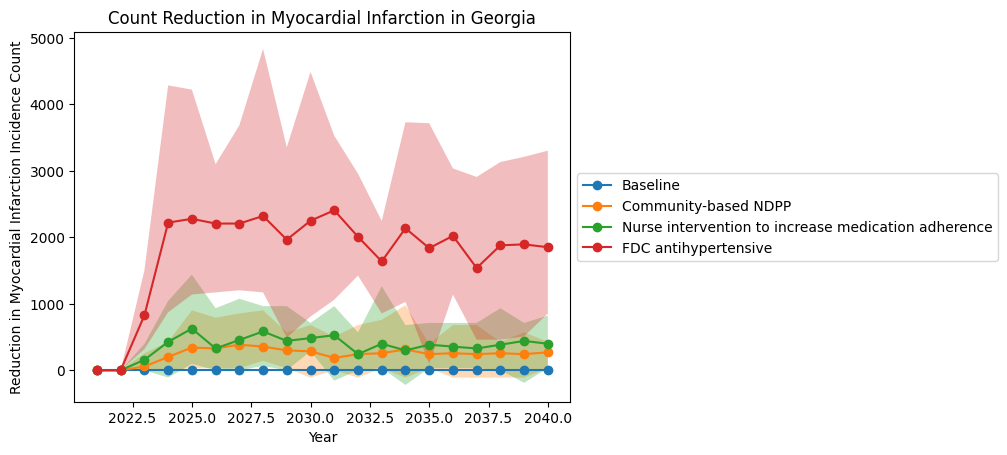

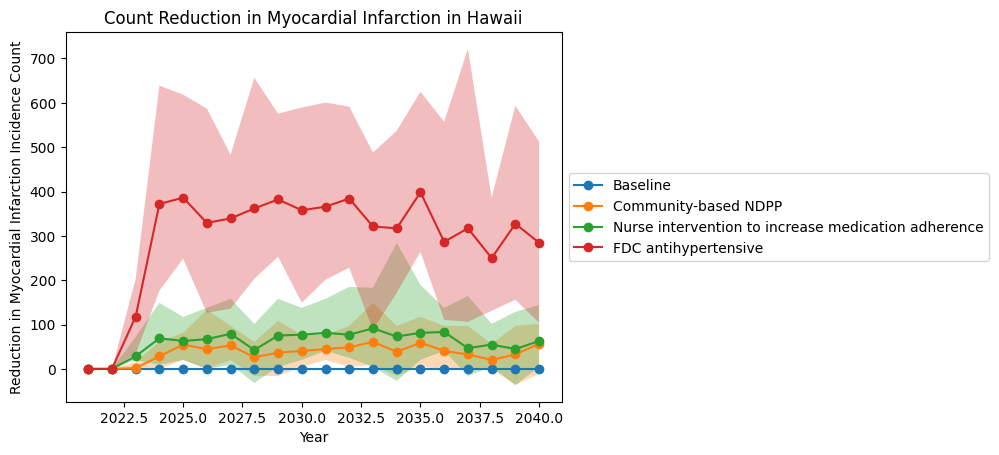

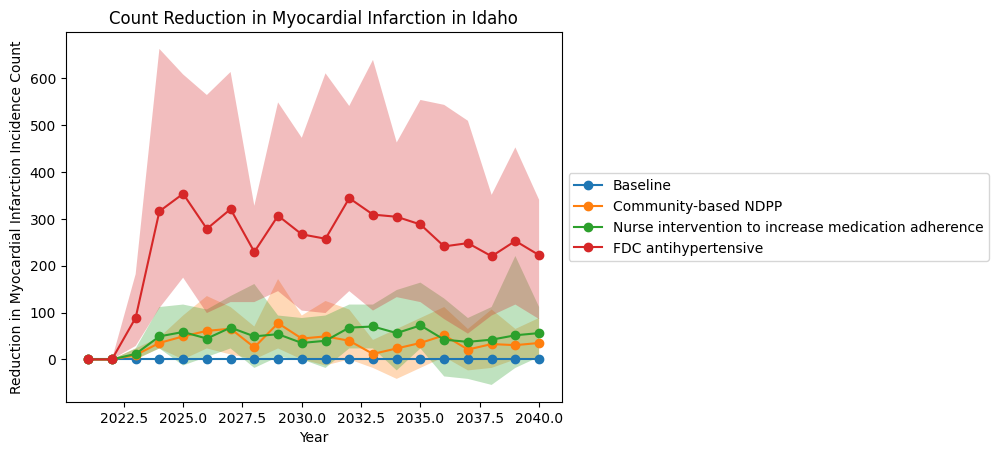

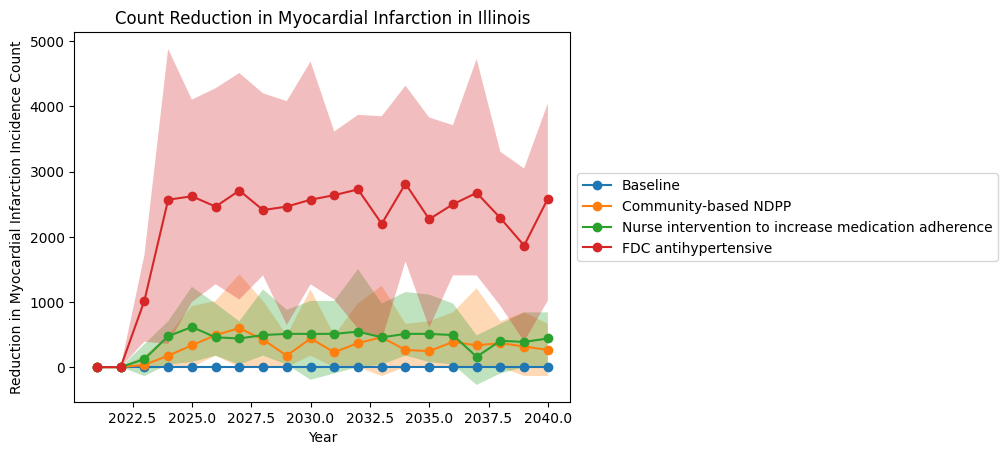

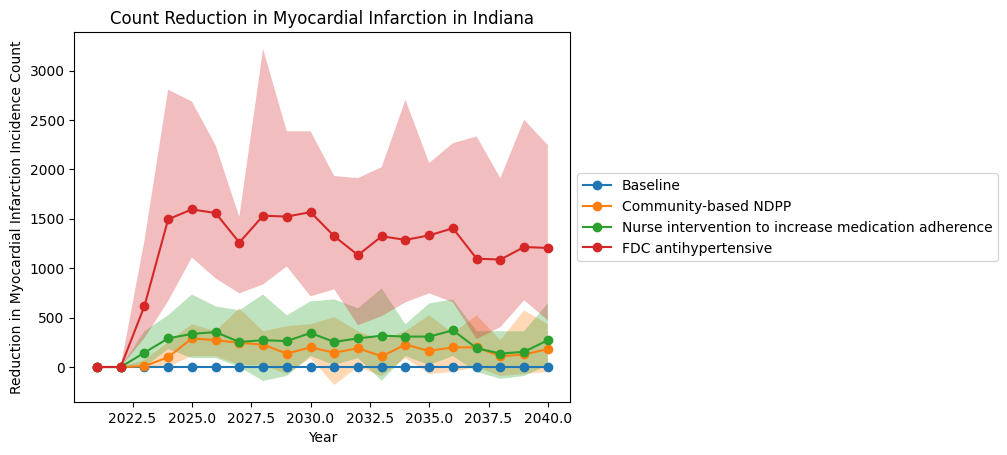

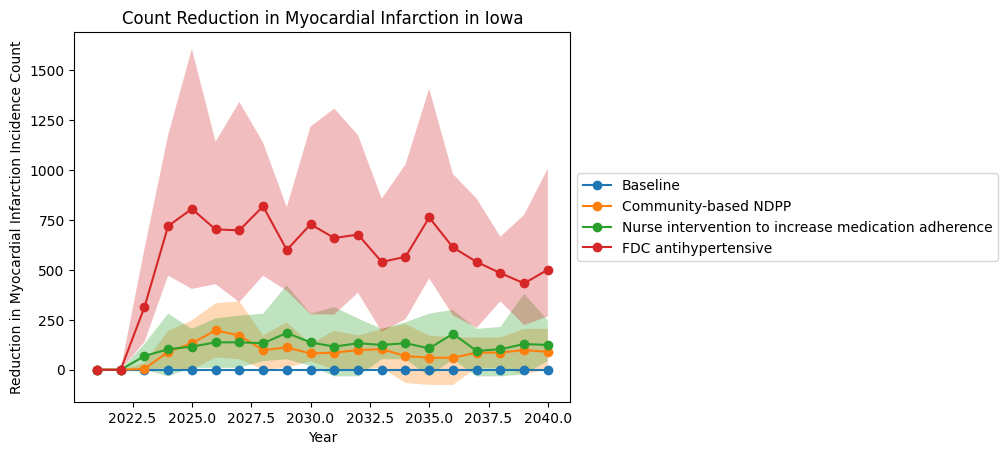

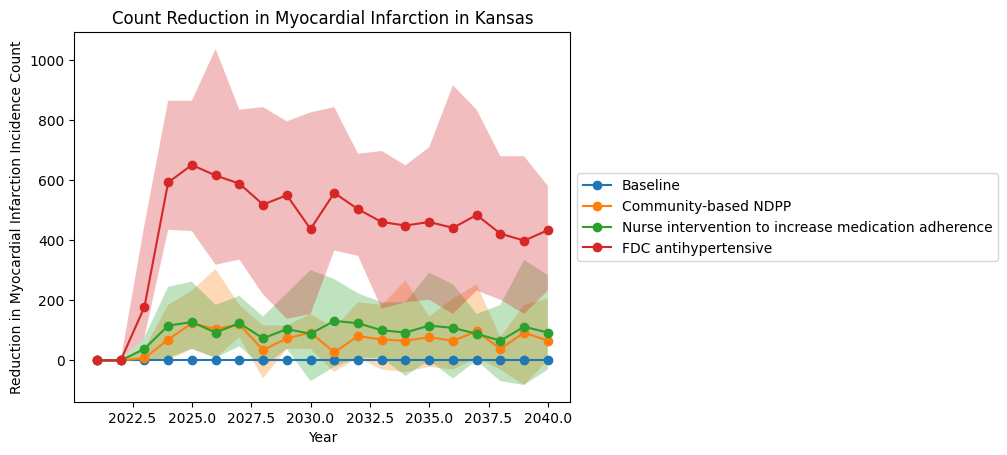

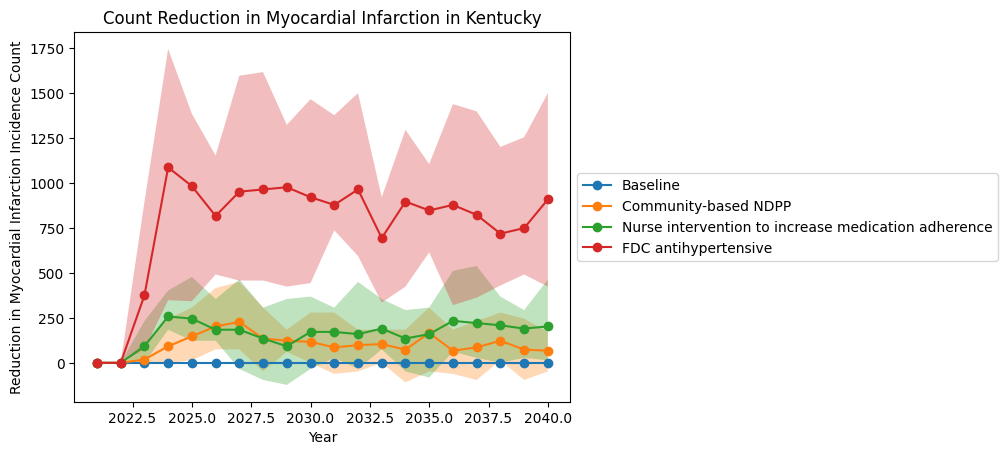

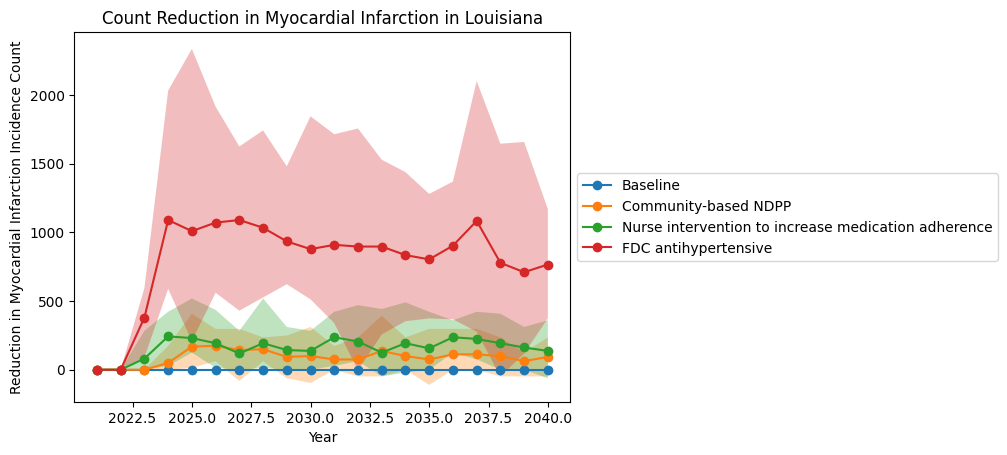

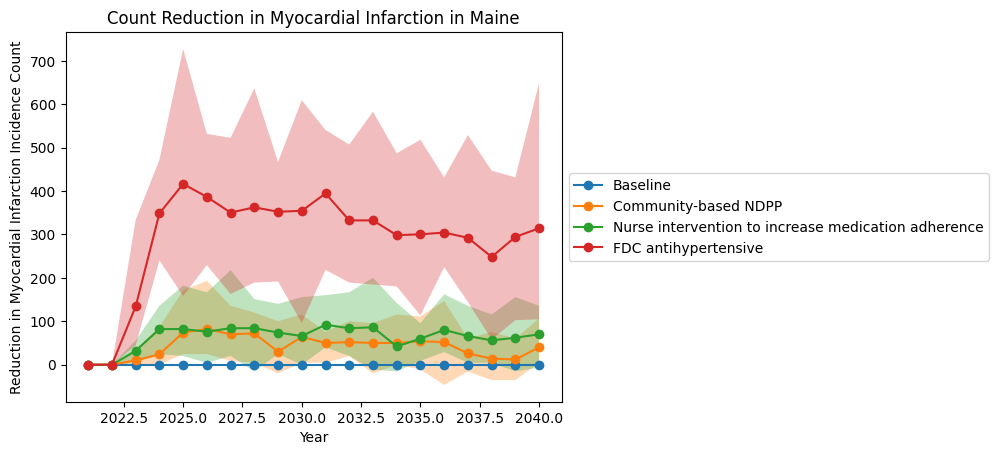

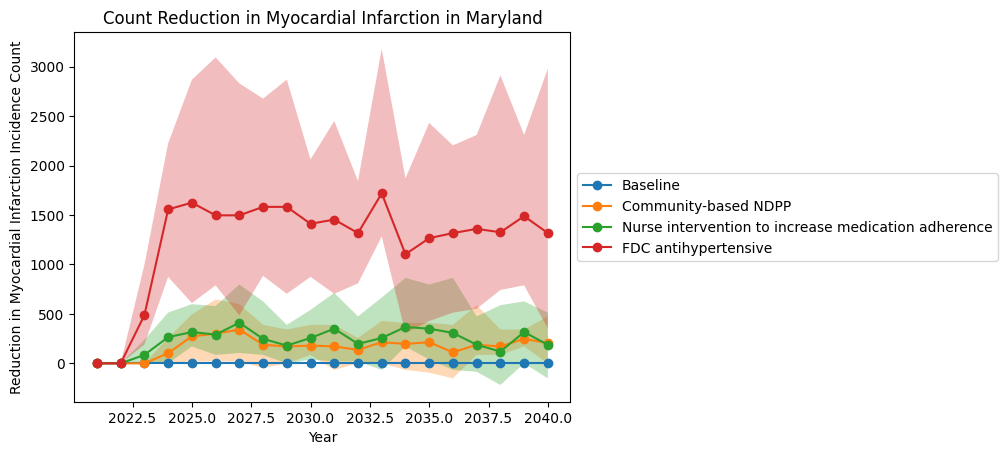

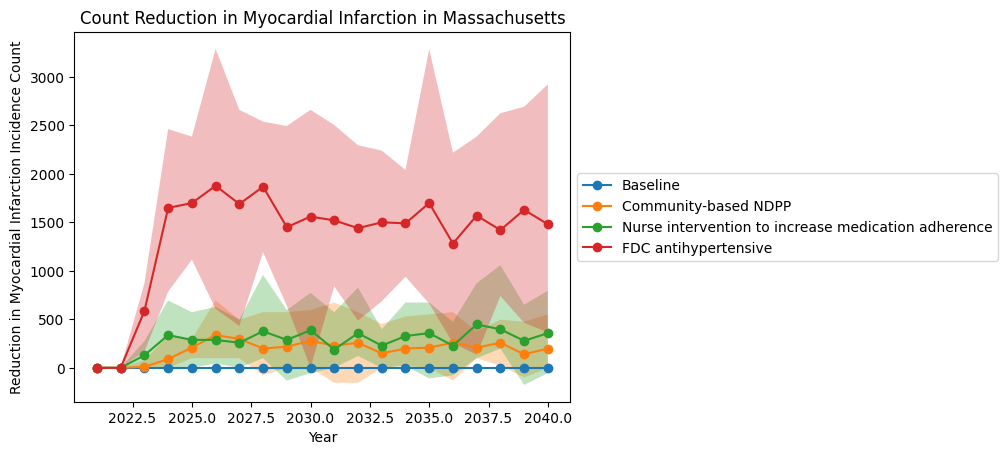

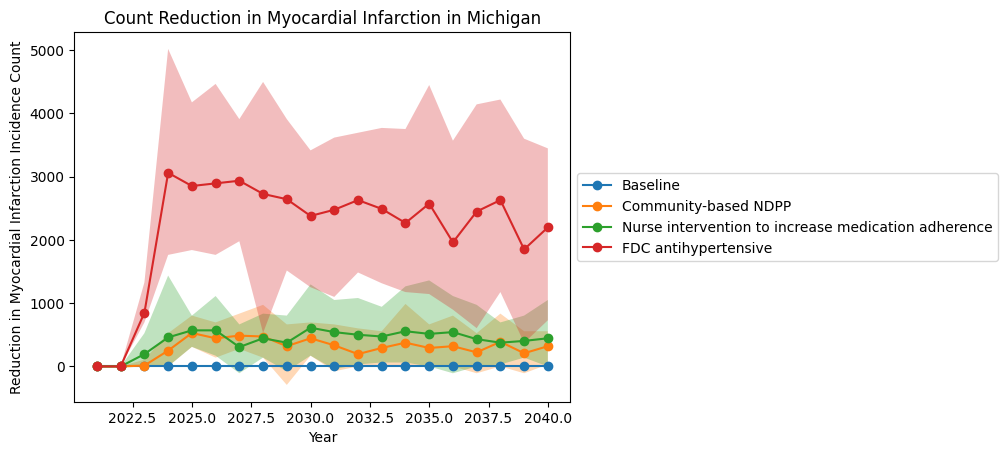

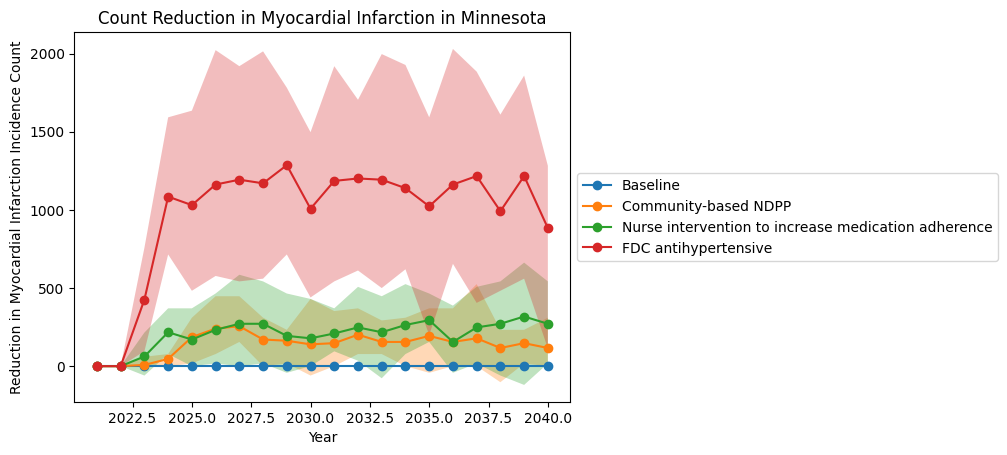

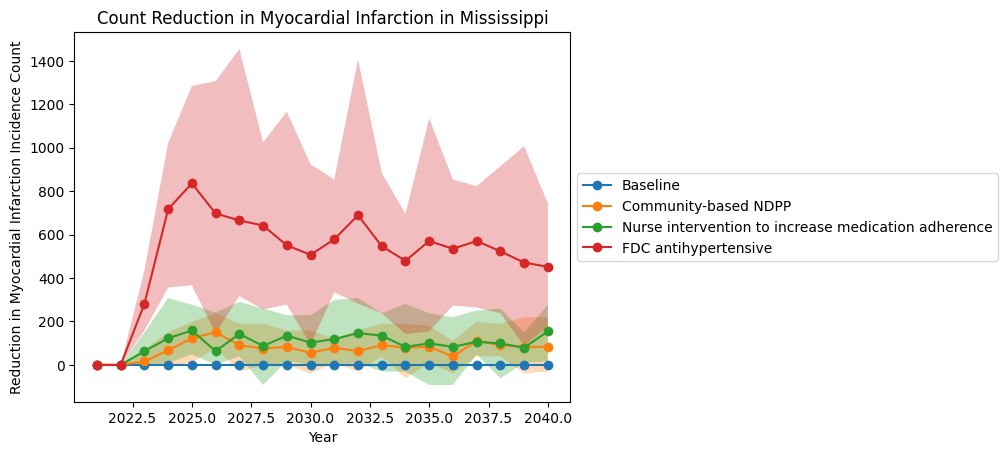

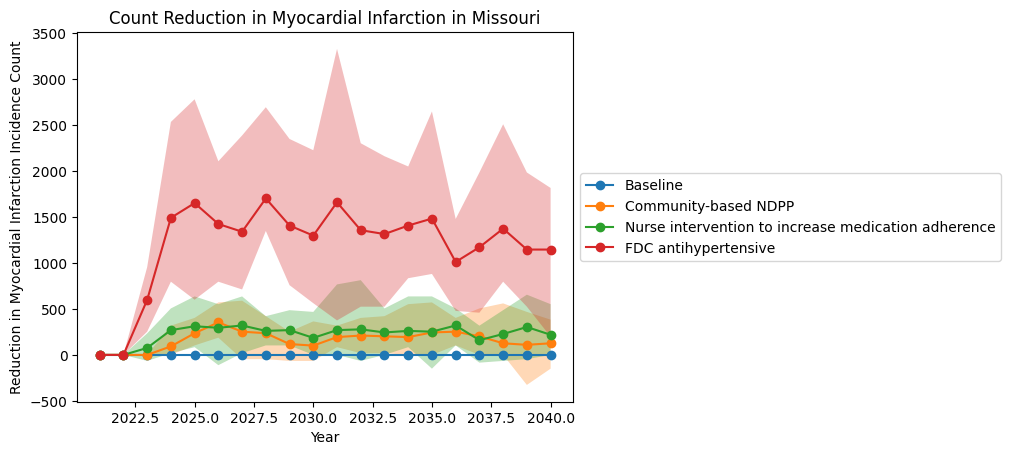

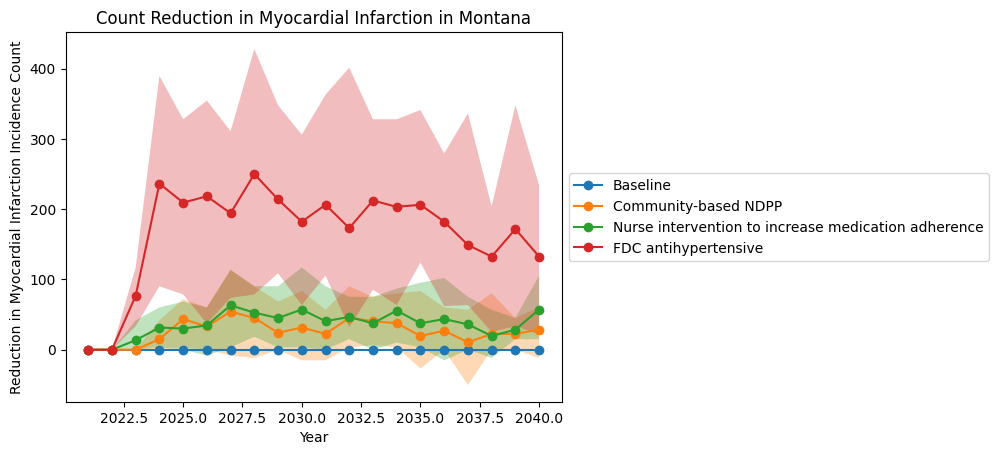

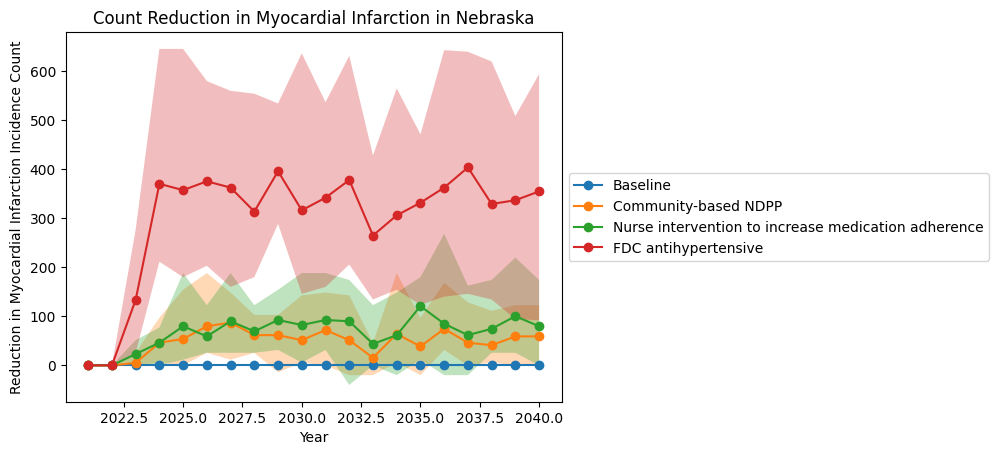

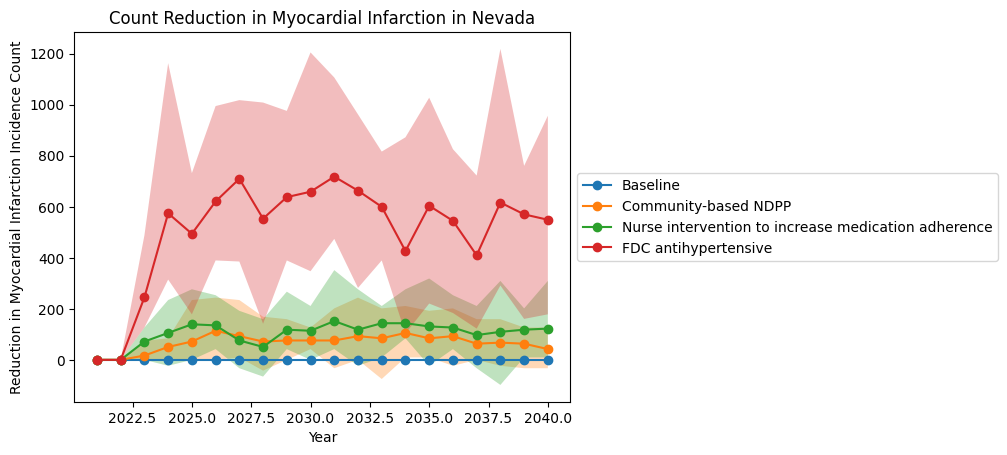

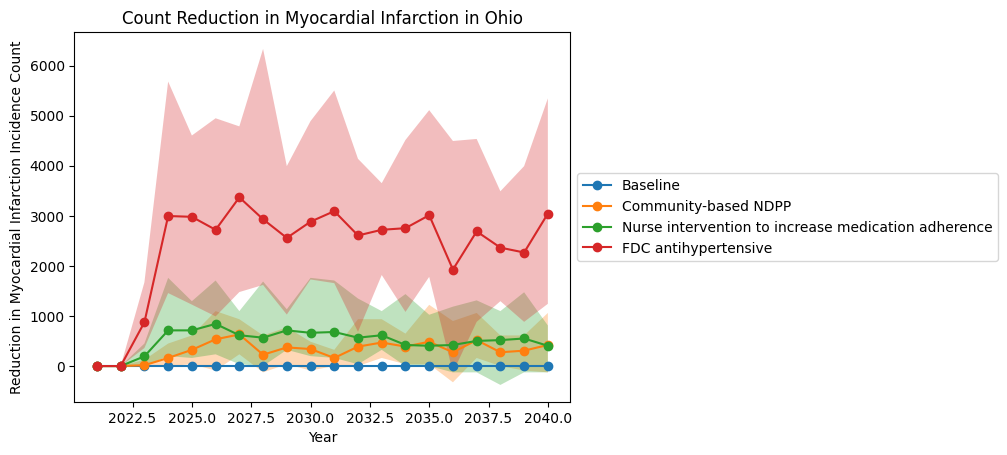

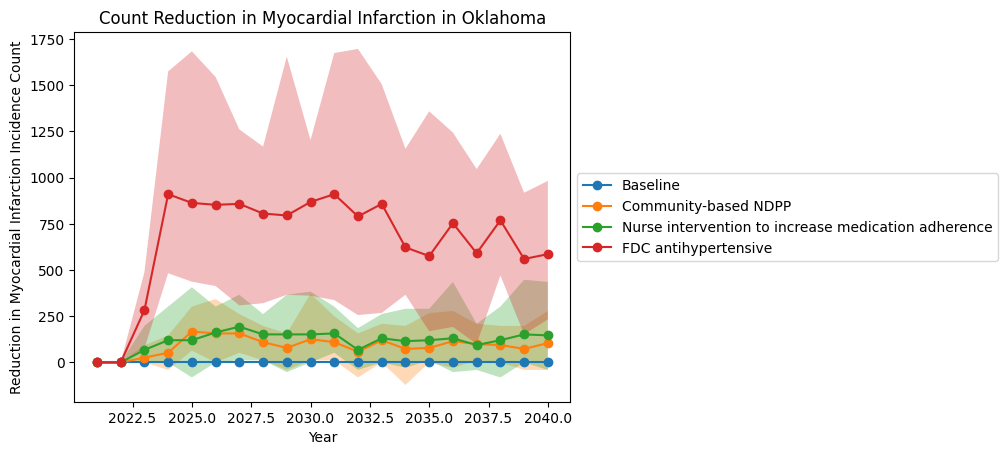

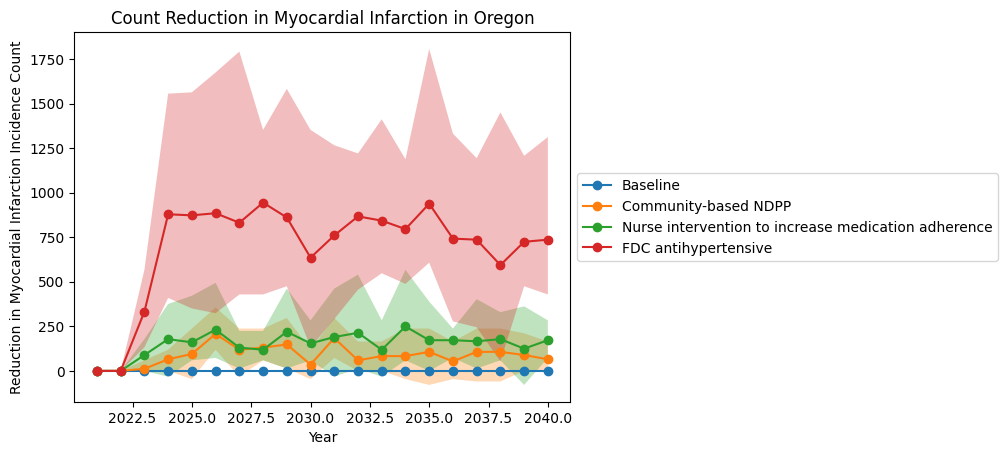

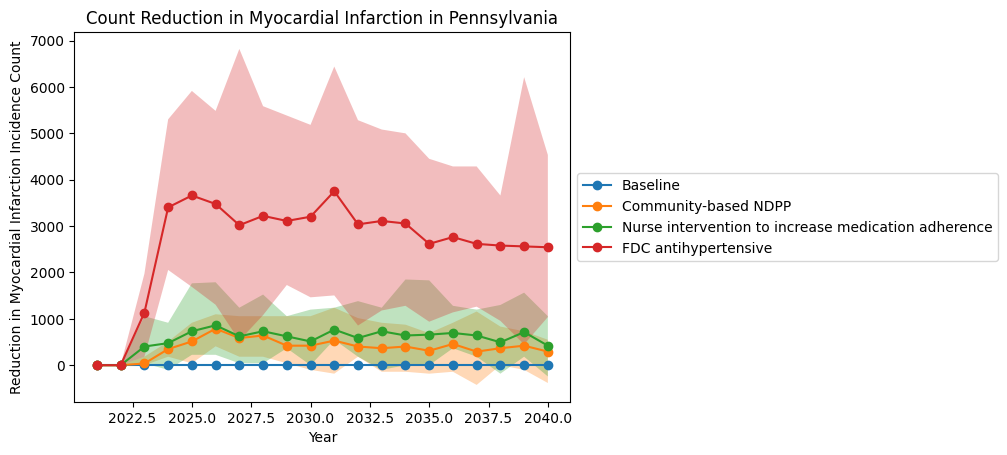

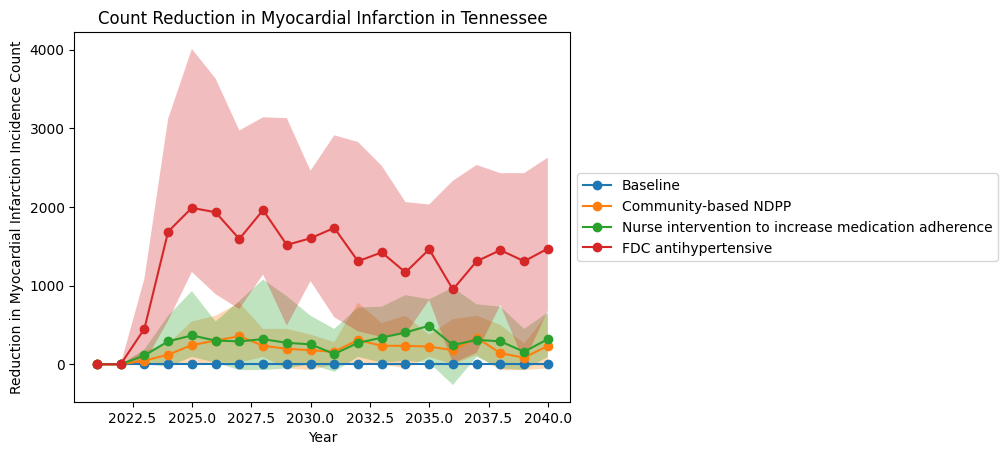

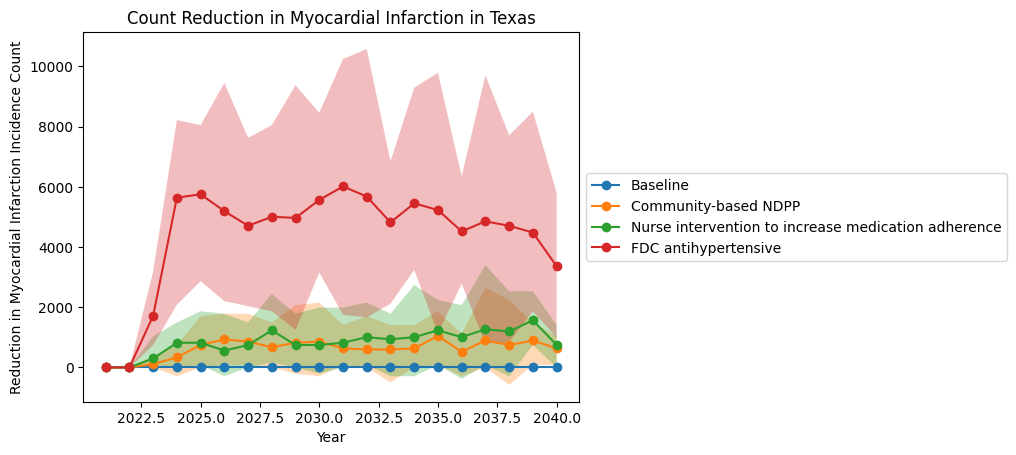

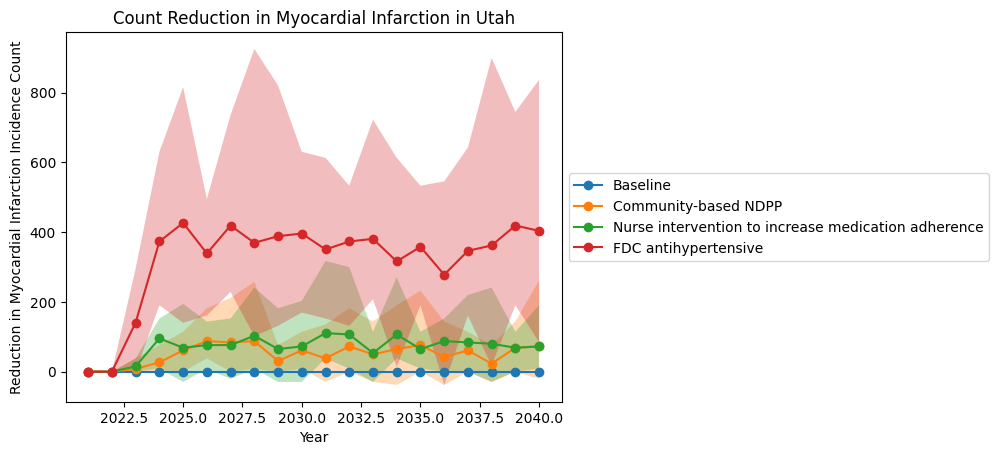

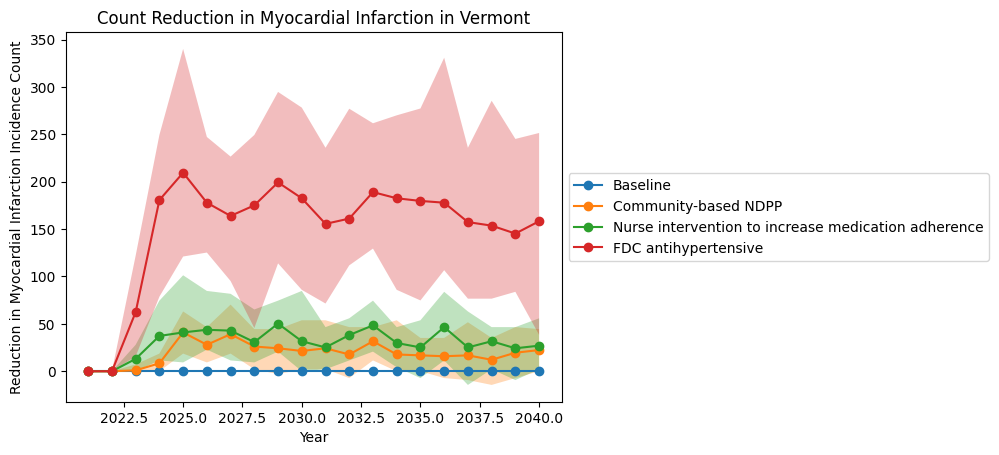

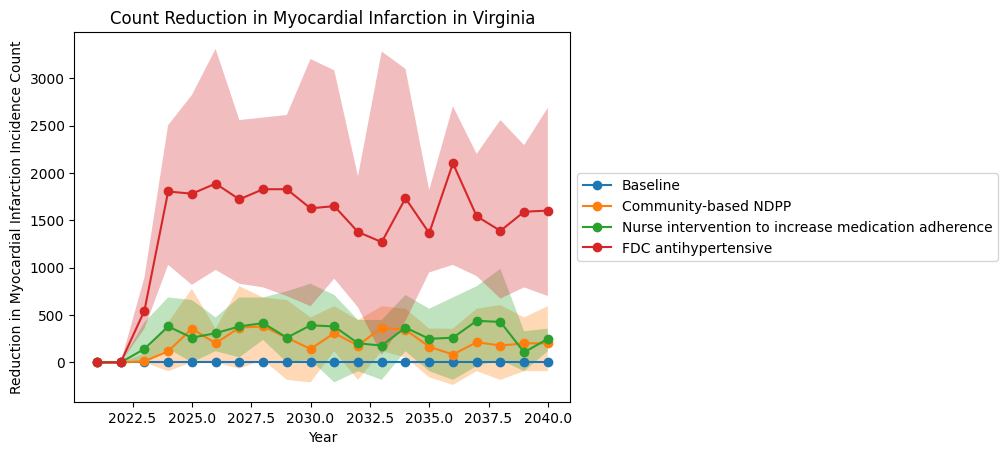

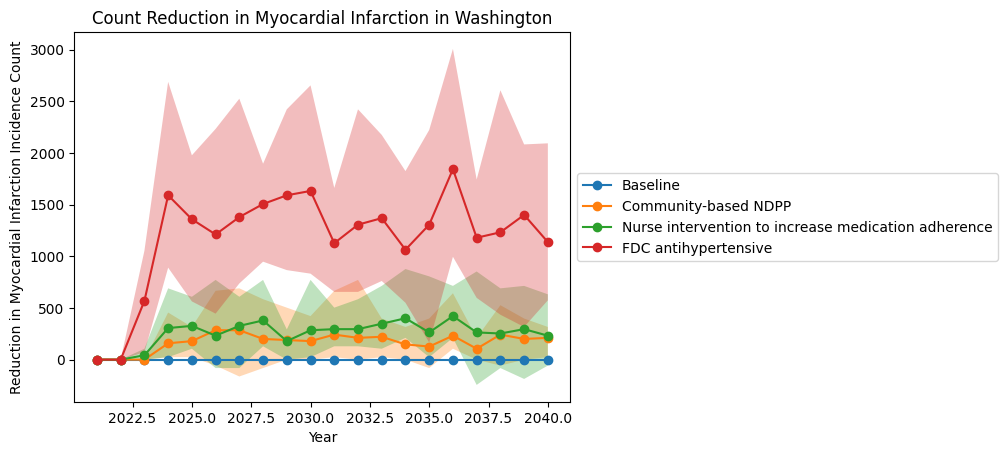

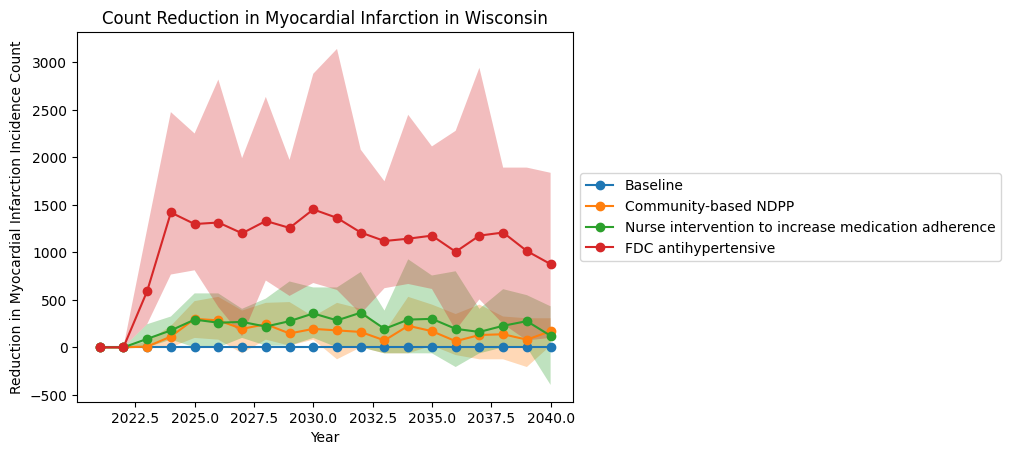

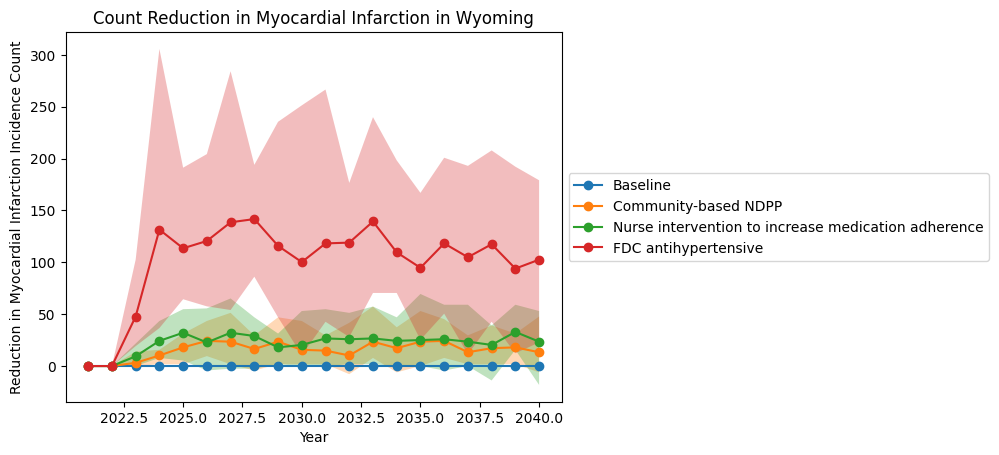

In [46]:
#%%capture
nih_state_graphs(tran_state_summ, 'Incidence', 'incidence_state_10_26_2023.pdf')

In [48]:
%%capture
us_graphs(daly_US_summ, 'DALYs', 'DALYs_us_08_16_2023.pdf')

In [54]:
%%capture
state_graphs(daly_state_summ, 'DALYs', 'DALYs_state_08_16_2023.pdf')

In [38]:
%%capture
total_outcome_scatter(tran_state_scatter, 'Incidence', 'incidence_scatter_08_07_2023.pdf')

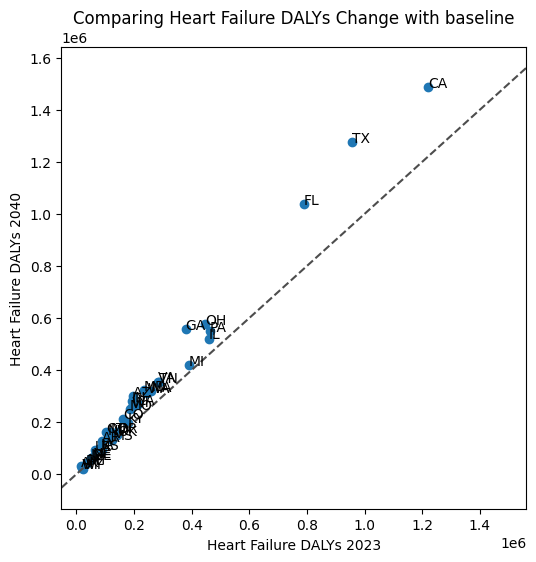

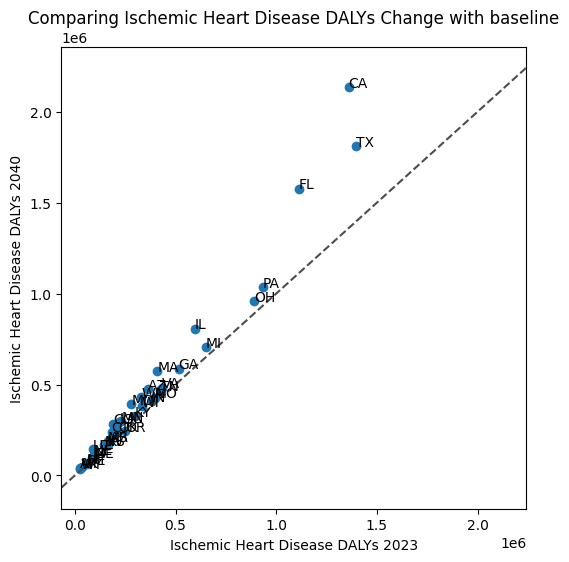

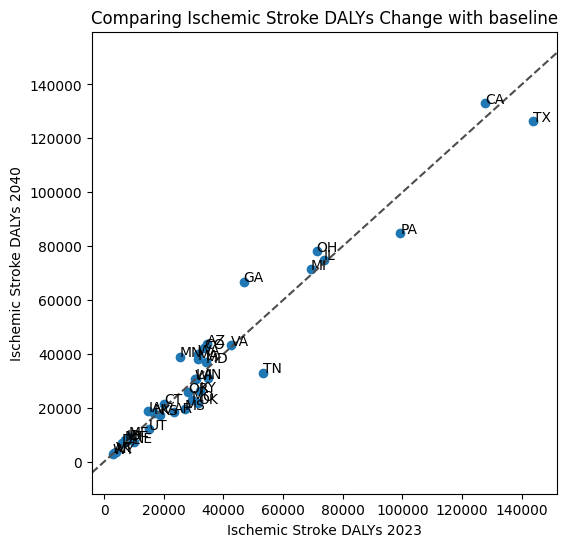

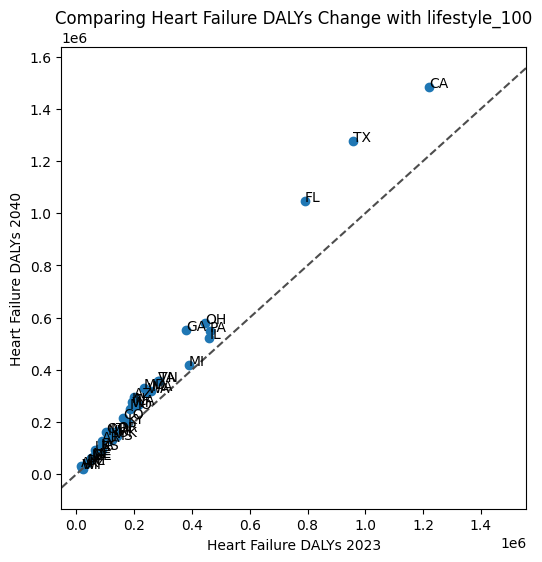

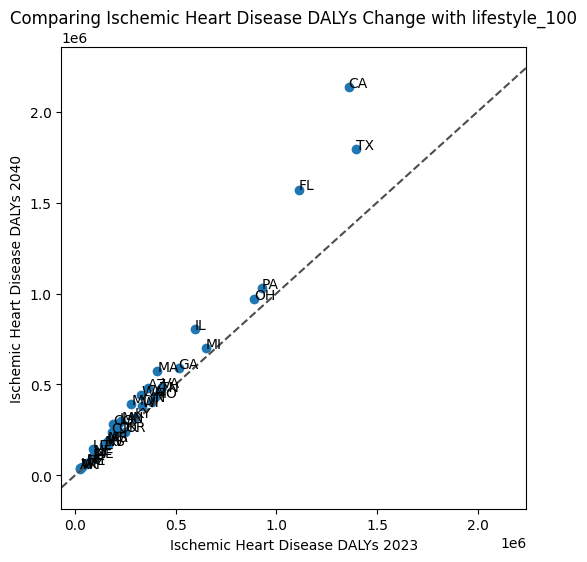

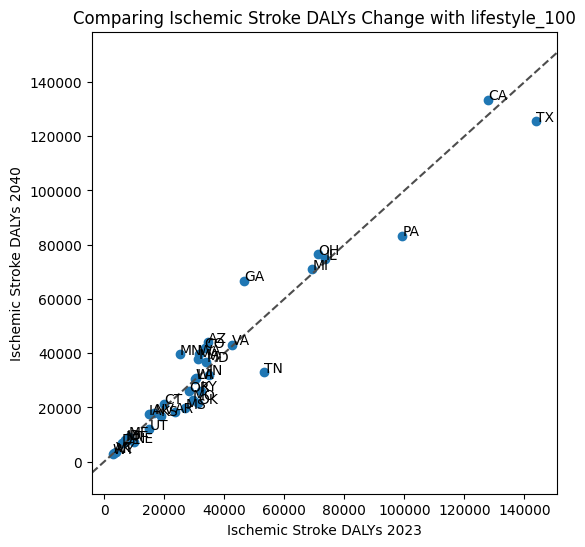

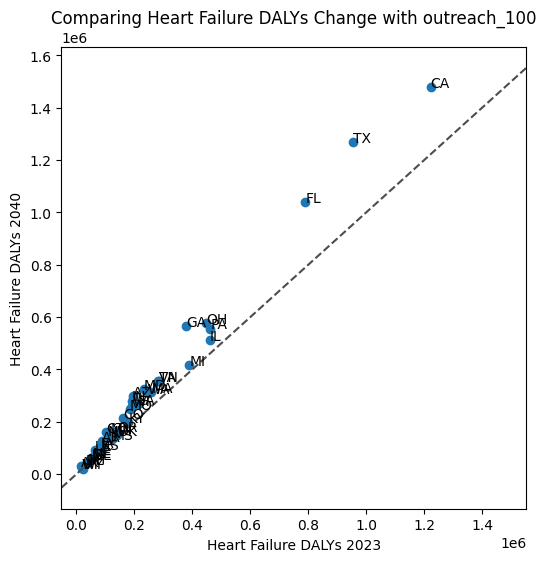

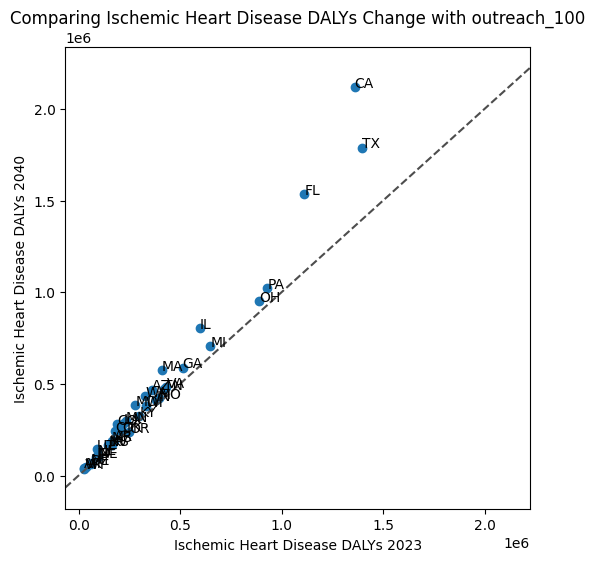

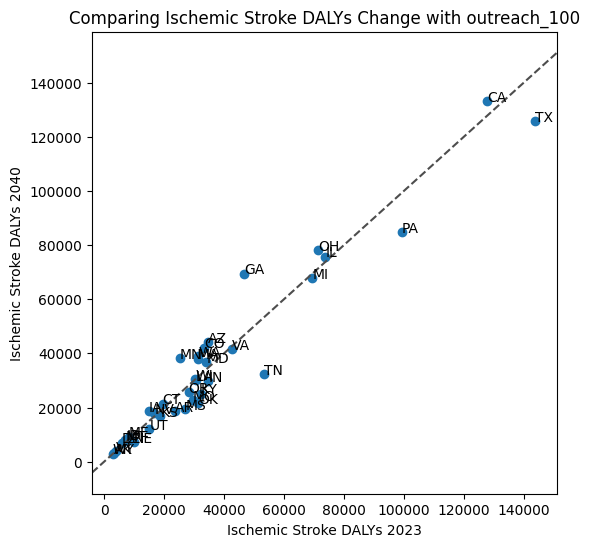

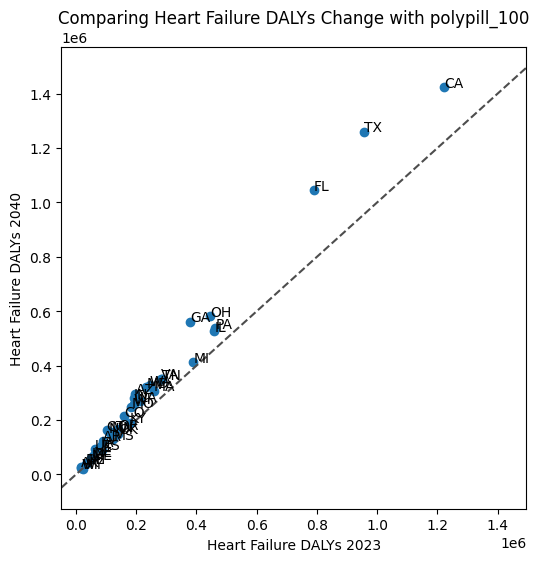

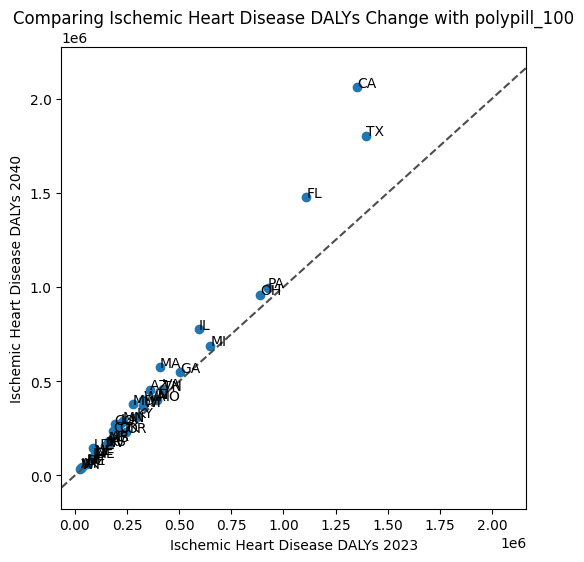

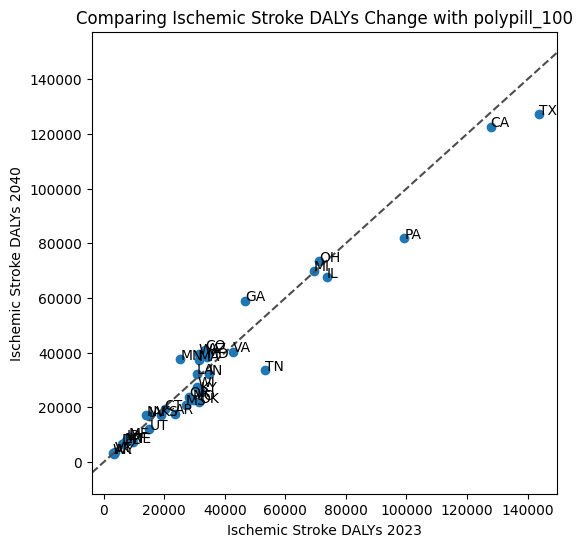

In [46]:
#%%capture
total_outcome_scatter(DALY_state_scatter, 'DALYs', 'DALY_scatter_08_07_2023.pdf')

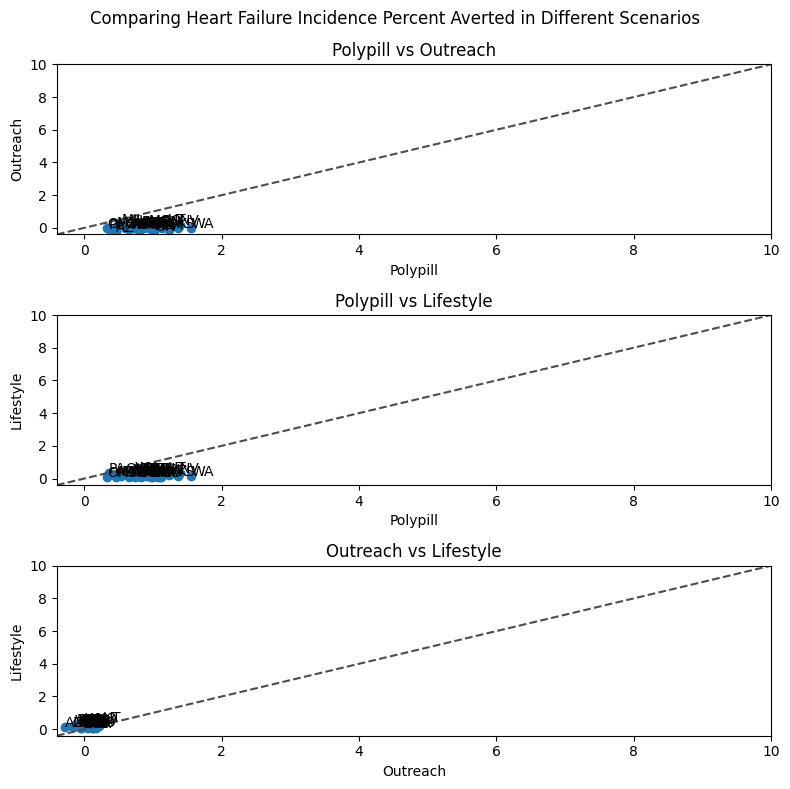

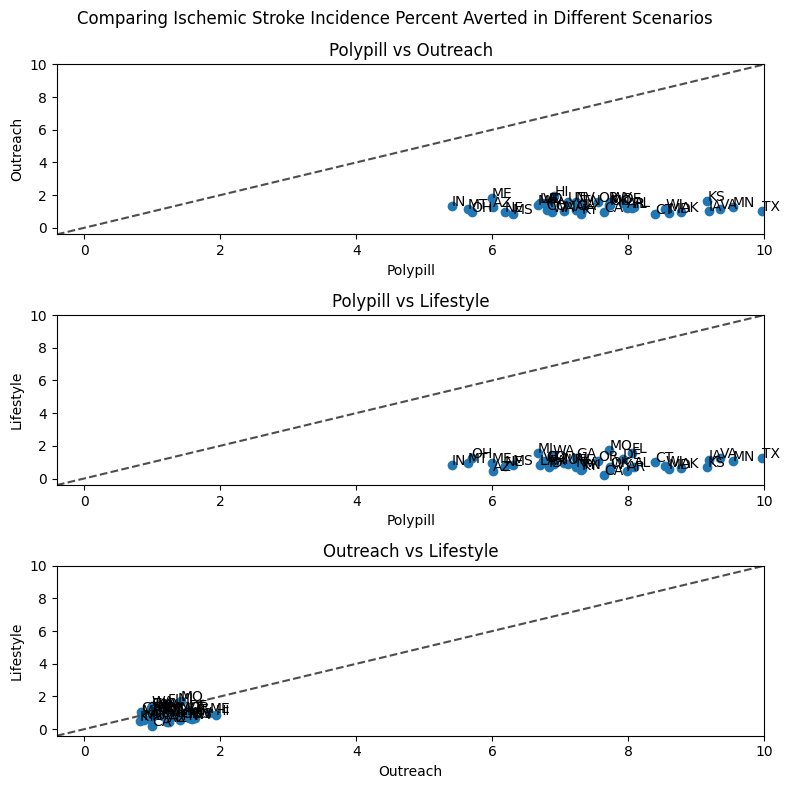

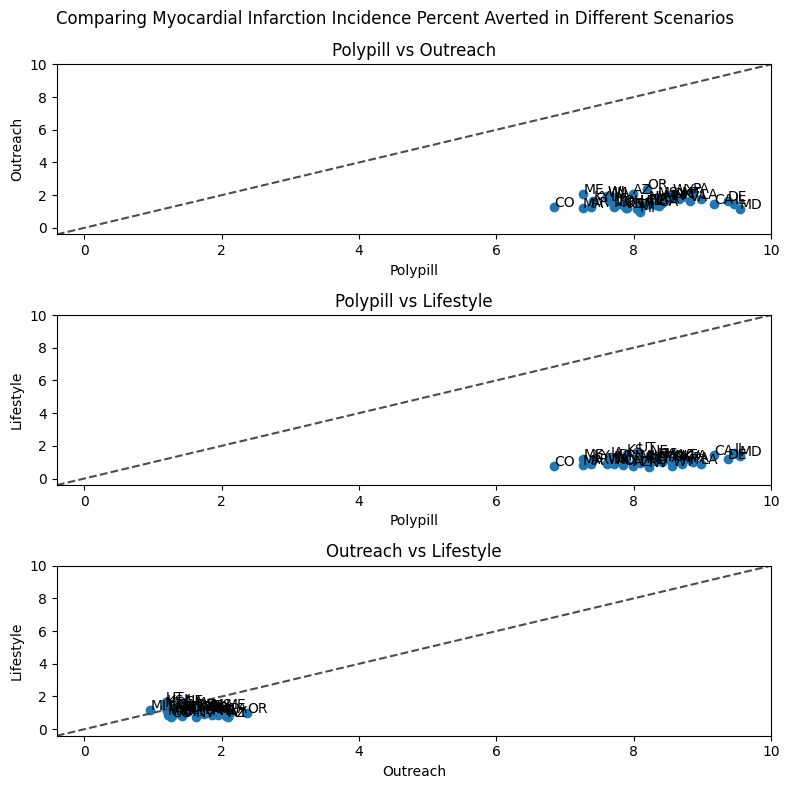

In [62]:
#%%capture
comparison_scatter(tran_state_allyear_summ, 'Incidence', 'incidence_comparison_scatter_08_09_2023.pdf')

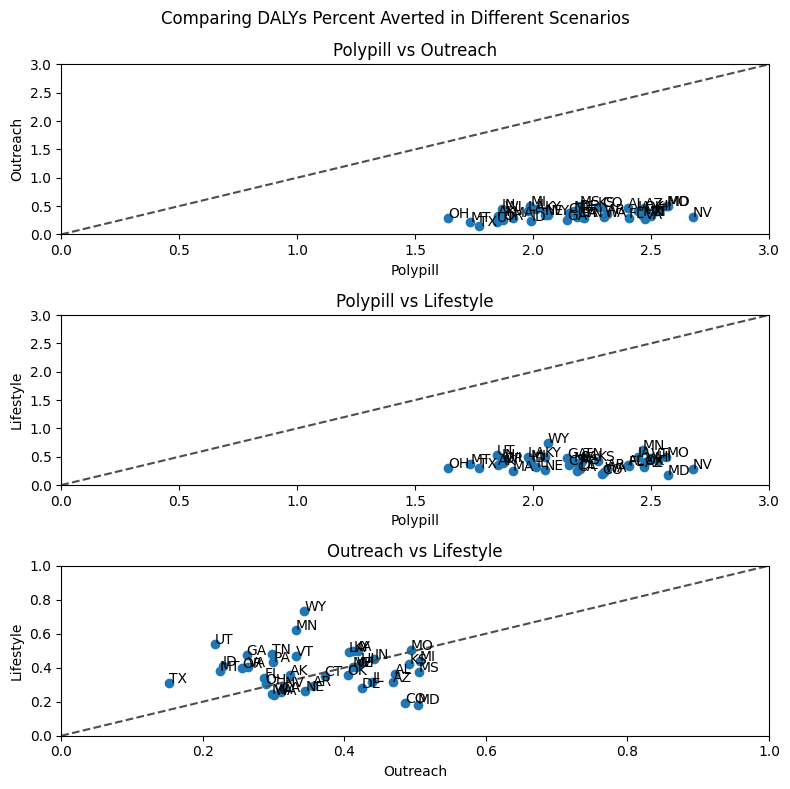

In [27]:
#%%capture
comparison_scatter(daly_state_allyear_summ, 'DALYs', 'DALY_comparison_scatter_08_14_2023.pdf')

In [61]:
%%capture
bar_chart_state(tran_state_scatter, 'Incidence', 'incidence_bar_chart_08_16_2023.pdf')

In [70]:
%%capture
bar_chart_state(DALY_state_scatter, 'DALYs', 'daly_bar_chart_08_16_2023.pdf')

In [65]:
%%capture
bar_chart_us(tran_us_scatter, 'Incidence', 'incidence_bar_chart_us_08_16_2023.pdf')

In [66]:
%%capture
bar_chart_us(DALY_us_scatter, 'DALYs', 'daly_bar_chart_us_08_16_2023.pdf')

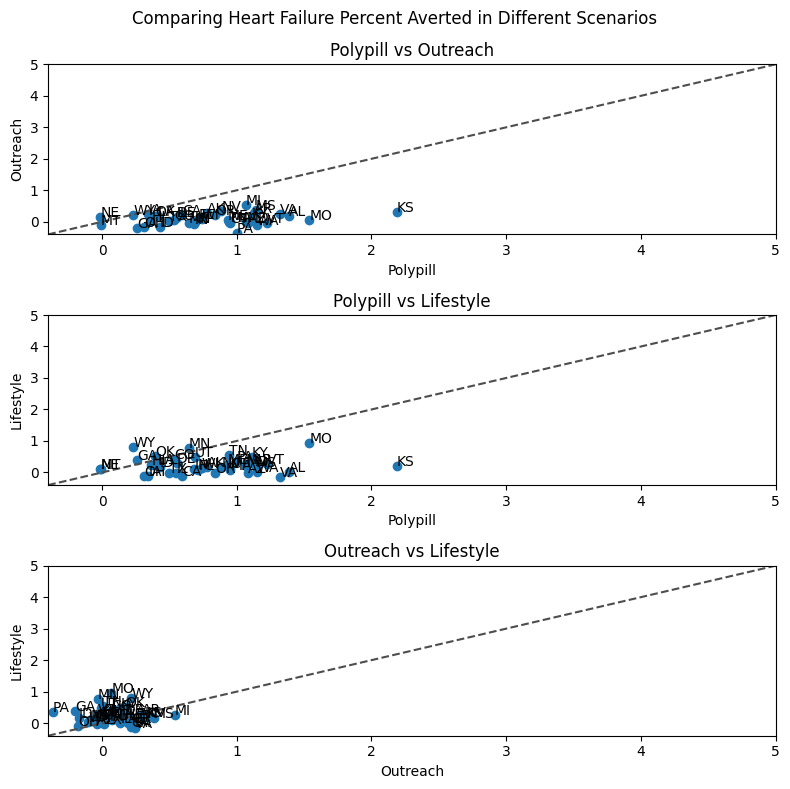

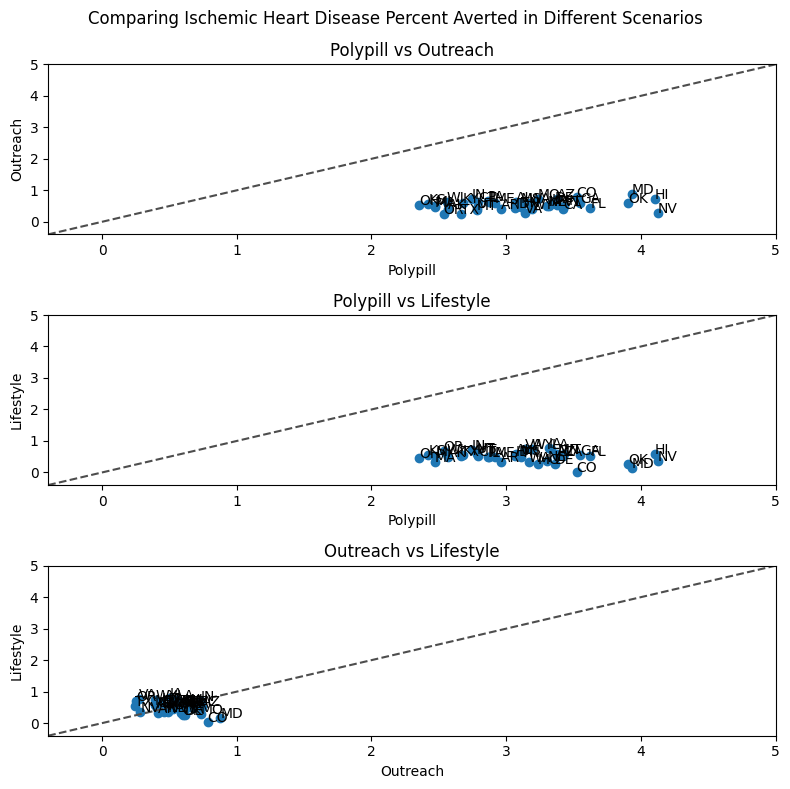

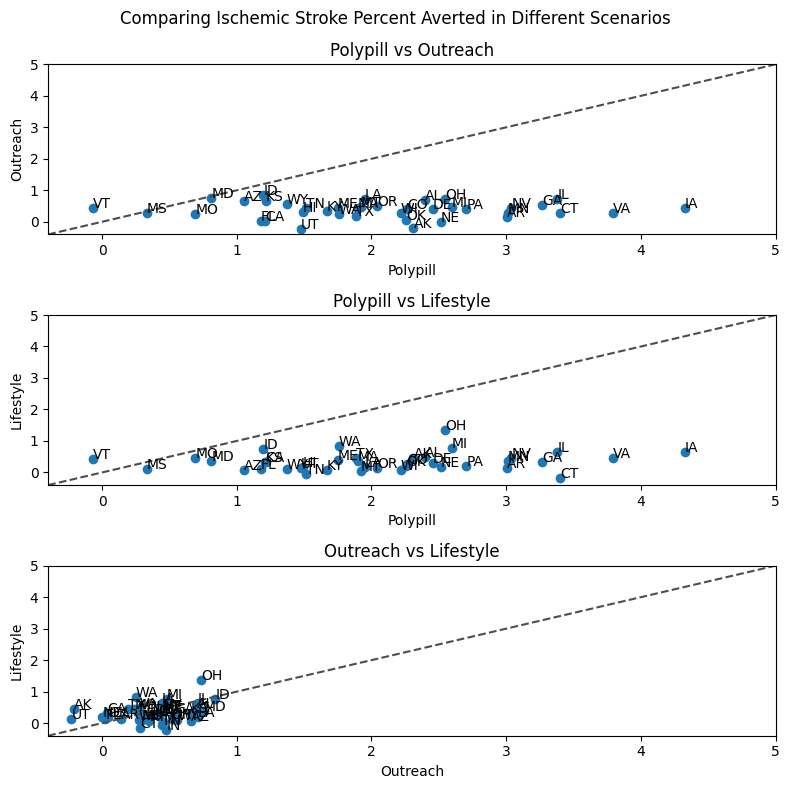

In [34]:
for tran in daly_state_allyear_summ.transition_new.unique(): 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))
    fig.tight_layout(pad=20)
    fig.suptitle(f'Comparing {tran} Percent Averted in Different Scenarios',)

    subdata_polypill = daly_state_allyear_summ.loc[(daly_state_allyear_summ.transition_new==tran) & (daly_state_allyear_summ.scenario=='polypill_100')]
    subdata_outreach = daly_state_allyear_summ.loc[(daly_state_allyear_summ.transition_new==tran) & (daly_state_allyear_summ.scenario=='outreach_100')]
    subdata_lifestyle = daly_state_allyear_summ.loc[(daly_state_allyear_summ.transition_new==tran) & (daly_state_allyear_summ.scenario=='lifestyle_100')]

    ax1.scatter(subdata_polypill.averted_percent_mean, subdata_outreach.averted_percent_mean, marker = 'o')

    for i in range(len(subdata_polypill)):
        ax1.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_outreach.averted_percent_mean.iloc[i] + 0.0002))

    ax1.set_xlabel(f'Polypill')
    ax1.set_ylabel(f'Outreach')
    #low_y, high_y = ax1.get_xlim()
    ax1.set_xlim(-0.4,5)
    ax1.set_ylim(-0.4,5)
    diag_line = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
    ax1.set_title(f'Polypill vs Outreach')



    ax2.scatter(subdata_polypill.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

    for i in range(len(subdata_polypill)):
        ax2.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

    ax2.set_xlabel(f'Polypill')
    ax2.set_ylabel(f'Lifestyle')
    ax2.set_xlim(-0.4,5)
    ax2.set_ylim(-0.4,5)
    diag_line = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
    ax2.set_title(f'Polypill vs Lifestyle')
    plt.tight_layout()


    ax3.scatter(subdata_outreach.averted_percent_mean, subdata_lifestyle.averted_percent_mean, marker = 'o')

    for i in range(len(subdata_outreach)):
        ax3.annotate(subdata_outreach.abbreviation.iloc[i], (subdata_outreach.averted_percent_mean.iloc[i], subdata_lifestyle.averted_percent_mean.iloc[i] + 0.0002))

    ax3.set_xlabel(f'Outreach')
    ax3.set_ylabel(f'Lifestyle')
    ax3.set_xlim(-0.4,5)
    ax3.set_ylim(-0.4,5)
    diag_line = ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
    ax3.set_title(f'Outreach vs Lifestyle')
    plt.tight_layout()
